In [1]:
import importlib
import os
from collections import defaultdict
import json
import shutil
import numpy as np
from pathlib import Path
from typing import Any, List, Callable, Union
import pandas as pd
from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.integration.keras import TuneReportCallback
from ray.air import session
import tensorflow as tf
from tqdm import tqdm
import yaml

import utils, model_zoo, hominid

2023-05-31 13:26:22.862857: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 13:26:23.934111: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-31 13:26:23.934191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-31 13:26:23.934198: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
def to_tfrecord(inputs, labels, path: str, indices: List[int] = None):

    def serialize_example(inputs, labels):

        inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
        inputs = tf.io.serialize_tensor(inputs).numpy()
        labels = tf.convert_to_tensor(labels, dtype=tf.float32)
        labels = tf.io.serialize_tensor(labels).numpy()

        feature = {
            "inputs": tf.train.Feature(bytes_list=tf.train.BytesList(value=[inputs])),
            "labels": tf.train.Feature(bytes_list=tf.train.BytesList(value=[labels])),
        }

        example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()

    def generator():
        for i in tqdm(range(len(inputs))):

            yield serialize_example(
                inputs=inputs[i],
                labels=labels[i],
            )

    serialized_features_dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=tf.string,
        output_shapes=()
    )

    writer = tf.data.experimental.TFRecordWriter(path)
    writer.write(serialized_features_dataset)


In [3]:
data_path = "/home/chandana/projects/hominid_pipeline/data"

# Load the data
x_train, y_train = utils.load_deepstarr_data("train", subsample=False)
x_valid, y_valid = utils.load_deepstarr_data("valid", subsample=False)
x_test, y_test = utils.load_deepstarr_data("test", subsample=False)

to_tfrecord(
    x_valid,
    y_valid,
    f"{data_path}/valid.tfrec"
)

to_tfrecord(
    x_train,
    y_train,
    f"{data_path}/train.tfrec"
)

to_tfrecord(
    x_test,
    y_test,
    f"{data_path}/test.tfrec"
)

print(x_test.shape)

Instructions for updating:
To write TFRecords to disk, use `tf.io.TFRecordWriter`. To save and load the contents of a dataset, use `tf.data.experimental.save` and `tf.data.experimental.load`


2023-05-31 13:26:48.582971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 13:26:49.107937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14239 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:81:00.0, compute capability: 8.6
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41186/41186 [00:24<00:00, 1669.13it/s]

(41186, 249, 4)


In [13]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128

DATA_DIR = "/home/chandana/projects/hominid_pipeline/data"
        

def parse_tfrecord(example):
    feature_description = {
        "inputs": tf.io.FixedLenFeature([], tf.string),
        "labels": tf.io.FixedLenFeature([], tf.string),
    }
    
    record = tf.io.parse_single_example(example, feature_description)
    record["inputs"] = tf.io.parse_tensor(record["inputs"], out_type=tf.float32)
    record["labels"] = tf.io.parse_tensor(record["labels"], out_type=tf.float32)

    inputs = tf.reshape(record["inputs"] , [249, 4]) # MAKE SURE TO CHANGE THIS!
    labels = tf.reshape(record["labels"], [2,]) # MAKE SURE TO CHANGE THIS!

    return inputs, labels

def load_dataset(filenames):

    records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    records = records.map(parse_tfrecord, num_parallel_calls=AUTO)

    return records

def get_dataset(batch_size: int, name: str):

    if name == "train":
        dataset = load_dataset([DATA_DIR + "/train.tfrec"])
        dataset = dataset.shuffle(10000)
        dataset = dataset.repeat()
    elif name == "valid":
        dataset = load_dataset([DATA_DIR + "/valid.tfrec"])
    elif name == "test":
        dataset = load_dataset([DATA_DIR + "/test.tfrec"])

    dataset = dataset.batch(batch_size).prefetch(AUTO) 

    return dataset

In [15]:
# here we load the dataset for training/evaluation
train_ds = get_dataset(BATCH_SIZE, name="train")
valid_ds = get_dataset(BATCH_SIZE, name="valid")
test_ds = get_dataset(BATCH_SIZE, name="test")

# Test TF Dataset

In [16]:
x = np.concatenate([x for x, y in test_ds], axis=0)
y = np.concatenate([y for x, y in test_ds], axis=0)

print(np.allclose(y_test, y))
print(np.allclose(x_test, x))

True
True


In [17]:
train_size = len(x_train)
valid_size = len(x_valid)
test_size = len(x_test)

total = train_size + valid_size + test_size

print("Train: ", train_size / total)
print("Validation: ", valid_size / total)
print("Validation: ", test_size / total)

Train:  0.8311007908241264
Validation:  0.08381330931387537
Validation:  0.0850858998619983


In [60]:
train_size, valid_size, test_size

(402296, 40570, 41186)

In [21]:
config = {
    'conv1_activation': 'exponential',
    'conv1_attention_pool_size': 5,
    'conv1_batchnorm': True,
    'conv1_channel_weight': 'se',
    'conv1_dropout': 0.3,
    'conv1_filters': 256, # this is 256
    'conv1_kernel_size': 15,
    'conv1_max_pool': 8,
    'conv1_pool_type': 'attention',
    'conv1_type': 'pw',
    'dense_activation': 'relu',
    'dense_batchnorm': True,
    'dense_dropout': [0.3, 0.3],
    'dense_units': [256, 128],
    'input_shape': (249, 4),
    'mha_d_model': 192,
    'mha_dropout': 0.1,
    'mha_head_type': 'task_specific',
    'mha_heads': 4,
    'mha_layernorm': False,
    'output_activation': 'linear',
    'output_shape': 2
}
config

{'conv1_activation': 'exponential',
 'conv1_attention_pool_size': 5,
 'conv1_batchnorm': True,
 'conv1_channel_weight': 'se',
 'conv1_dropout': 0.3,
 'conv1_filters': 256,
 'conv1_kernel_size': 15,
 'conv1_max_pool': 8,
 'conv1_pool_type': 'attention',
 'conv1_type': 'pw',
 'dense_activation': 'relu',
 'dense_batchnorm': True,
 'dense_dropout': [0.3, 0.3],
 'dense_units': [256, 128],
 'input_shape': (249, 4),
 'mha_d_model': 192,
 'mha_dropout': 0.1,
 'mha_head_type': 'task_specific',
 'mha_heads': 4,
 'mha_layernorm': False,
 'output_activation': 'linear',
 'output_shape': 2}

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 249, 4)]     0           []                               
                                                                                                  
 pairwise_conv1d (PairwiseConv1  (None, 249, 256)    468736      ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 249, 256)     1024        ['pairwise_conv1d[0][0]']        
                                                                                                  
 conv1_activation (Activation)  (None, 249, 256)     0           ['conv1_bn[0][0]']           

 dense_15 (Dense)               (None, 1)            257         ['dropout_5[0][0]']              
                                                                                                  
 tf.concat (TFOpLambda)         (None, 2)            0           ['dense_7[0][0]',                
                                                                  'dense_15[0][0]']               
                                                                                                  
Total params: 3,298,114
Trainable params: 3,295,554
Non-trainable params: 2,560
__________________________________________________________________________________________________


In [36]:
model = model_zoo.base_model(**config)


model.compile(
    tf.keras.optimizers.Adam(lr=0.001),
    loss='mse',
    metrics=[utils.Spearman, utils.pearson_r]
)
model.summary()

train_steps = train_size // BATCH_SIZE
valid_steps = valid_size // BATCH_SIZE


history = model.fit(
    train_ds,
    epochs=5,
    steps_per_epoch=train_steps, 
    validation_data=valid_ds,
    validation_steps=valid_steps,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, verbose=1,
        mode='min', restore_best_weights=True
    ),
        tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, mode='min', verbose=1
        )
    ]
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 249, 4)]     0           []                               
                                                                                                  
 pairwise_conv1d (PairwiseConv1  (None, 249, 256)    468736      ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 249, 256)     1024        ['pairwise_conv1d[0][0]']        
                                                                                                  
 conv1_activation (Activation)  (None, 249, 256)     0           ['conv1_bn[0][0]']           

 dense_15 (Dense)               (None, 1)            257         ['dropout_5[0][0]']              
                                                                                                  
 tf.concat (TFOpLambda)         (None, 2)            0           ['dense_7[0][0]',                
                                                                  'dense_15[0][0]']               
                                                                                                  
Total params: 3,298,114
Trainable params: 3,295,554
Non-trainable params: 2,560
__________________________________________________________________________________________________
Epoch 1/5
3142/3142 [==============================] - 125s 37ms/step - loss: 2.3586 - Spearman: 0.3795 - pearson_r: 0.2796 - val_loss: 2.5525 - val_Spearman: 0.3869 - val_pearson_r: 0.3331 - lr: 0.0010
Epoch 2/5
3142/3142 [==============================] - 118s 38ms/step - loss: 1.8604 - Spearman: 0.5380 - pearson_r: 0.5101

KeyboardInterrupt: 

In [37]:
model = model_zoo.base_model(**config)


model.compile(
    tf.keras.optimizers.Adam(lr=0.001),
    loss='mse',
    metrics=[utils.Spearman, utils.pearson_r]
)
model.summary()

model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=128,
    # verbose=0,
    shuffle=True,
    validation_data=(x_valid, y_valid),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, verbose=1,
        mode='min', restore_best_weights=True
    ),
        tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, mode='min', verbose=1
        )
    ]
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 249, 4)]     0           []                               
                                                                                                  
 pairwise_conv1d (PairwiseConv1  (None, 249, 256)    468736      ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 249, 256)     1024        ['pairwise_conv1d[0][0]']        
                                                                                                  
 conv1_activation (Activation)  (None, 249, 256)     0           ['conv1_bn[0][0]']           

 dense_15 (Dense)               (None, 1)            257         ['dropout_5[0][0]']              
                                                                                                  
 tf.concat (TFOpLambda)         (None, 2)            0           ['dense_7[0][0]',                
                                                                  'dense_15[0][0]']               
                                                                                                  
Total params: 3,298,114
Trainable params: 3,295,554
Non-trainable params: 2,560
__________________________________________________________________________________________________
Epoch 1/5
3143/3143 [==============================] - 128s 39ms/step - loss: 2.4422 - Spearman: 0.4686 - pearson_r: 0.3396 - val_loss: 1.8434 - val_Spearman: 0.5722 - val_pearson_r: 0.5138 - lr: 0.0010
Epoch 2/5
1219/3143 [==========>...................] - ETA: 1:10 - loss: 1.7909 - Spearman: 0.6174 - pearson_r: 0.6099

KeyboardInterrupt: 

In [35]:
model.layers[2].output_shape

int

In [2]:
importlib.reload(hominid)

<module 'hominid' from '/home/chandana/projects/hominid_pipeline/hominid.py'>

In [40]:
working_dir = "/home/chandana/projects/hominid_pipeline"

In [41]:
hits = [
"experiments/sweeps/tune_hominid_8f34a_00085_85_conv1_activation=exponential,conv1_attention_pool_size=23,conv1_batchnorm=True,conv1_channel_weight=se_2023-05-18_00-04-12",
"experiments/sweeps/tune_hominid_8f34a_00185_185_conv1_activation=relu,conv1_attention_pool_size=23,conv1_batchnorm=True,conv1_channel_weight=softconv_2023-05-18_06-11-38",
"experiments/model_variations/tune_hominid_8f34a_00058_58_conv1_activation=relu,conv1_attention_pool_size=30,conv1_batchnorm=False,conv1_channel_weight=softconv_2023-05-17_22-09-59/exponential",
"experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/exponential"
]

In [53]:
data = []
for index in range(len(hits)):
    config_file = f"{working_dir}/{hits[index]}/config.yaml"
    config = hominid.load_config(config_file)

    for key in config:
    
        config[key] = [config[key]]


    frame = pd.DataFrame(config)
    
    data += [frame]

In [56]:
df = pd.concat(data, axis=0)
df

,conv1_activation,conv1_attention_pool_size,conv1_batchnorm,conv1_channel_weight,conv1_dropout,conv1_filters,conv1_kernel_size,conv1_max_pool,conv1_pool_type,conv1_type,...,dense_dropout,dense_units,input_shape,mha_d_model,mha_dropout,mha_head_type,mha_heads,mha_layernorm,output_activation,output_shape
0,exponential,23,True,se,0.1,256,11,0,max_pool,pw,...,"[0.4, 0.4]","[128, 128]","(249, 4)",96,0.0,task_specific,8,False,linear,2
0,relu,23,True,softconv,0.3,96,19,8,max_pool,standard,...,"[0.3, 0.3]","[512, 512]","(249, 4)",192,0.2,pool,4,False,linear,2
0,exponential,30,True,softconv,0.3,128,15,8,max_pool,pw,...,"[0.4, 0.4]","[128, 128]","(249, 4)",96,0.1,pool,8,False,linear,2
0,exponential,5,True,se,0.3,256,15,8,attention,pw,...,"[0.3, 0.3]","[256, 128]","(249, 4)",192,0.1,task_specific,4,False,linear,2


In [58]:
df.T

,0,0,0,0
conv1_activation,exponential,relu,exponential,exponential
conv1_attention_pool_size,23,23,30,5
conv1_batchnorm,True,True,True,True
conv1_channel_weight,se,softconv,softconv,se
conv1_dropout,0.1,0.3,0.3,0.3
conv1_filters,256,96,128,256
conv1_kernel_size,11,19,15,15
conv1_max_pool,0,8,8,8
conv1_pool_type,max_pool,max_pool,max_pool,attention
conv1_type,pw,standard,pw,pw


In [50]:
# [[config[key]] for key in config]

# config.keys()


 

{'conv1_activation': ['exponential'],
 'conv1_attention_pool_size': [5],
 'conv1_batchnorm': [True],
 'conv1_channel_weight': ['se'],
 'conv1_dropout': [0.3],
 'conv1_filters': [256],
 'conv1_kernel_size': [15],
 'conv1_max_pool': [8],
 'conv1_pool_type': ['attention'],
 'conv1_type': ['pw'],
 'dense_activation': ['relu'],
 'dense_batchnorm': [True],
 'dense_dropout': [[0.3, 0.3]],
 'dense_units': [[256, 128]],
 'input_shape': [(249, 4)],
 'mha_d_model': [192],
 'mha_dropout': [0.1],
 'mha_head_type': ['task_specific'],
 'mha_heads': [4],
 'mha_layernorm': [False],
 'output_activation': ['linear'],
 'output_shape': [2]}

,conv1_activation,conv1_attention_pool_size,conv1_batchnorm,conv1_channel_weight,conv1_dropout,conv1_filters,conv1_kernel_size,conv1_max_pool,conv1_pool_type,conv1_type,...,dense_dropout,dense_units,input_shape,mha_d_model,mha_dropout,mha_head_type,mha_heads,mha_layernorm,output_activation,output_shape
0,exponential,5,True,se,0.3,256,15,8,attention,pw,...,"[0.3, 0.3]","[256, 128]","(249, 4)",192,0.1,task_specific,4,False,linear,2


In [ ]:
index = 3
config_file = f"{working_dir}/{hits[index]}/config.yaml"
config = hominid.load_config(config_file)

variation_index = 0
save_path = f"{working_dir}/{hits[index]}/variations/variation_{variation_index}"
utils.make_directory(save_path)

config

# config = {
#     'conv1_activation': 'exponential',
#     'conv1_attention_pool_size': 23,
#     'conv1_batchnorm': True,
#     'conv1_channel_weight': 'se',
#     'conv1_dropout': 0.1,
#     'conv1_filters': 128,
#     'conv1_kernel_size': 15,
#     'conv1_max_pool': 8,
#     'conv1_pool_type': 'max_pool',
#     'conv1_type': 'pw',
#     'dense_activation': 'relu',
#     'dense_batchnorm': True,
#     'dense_dropout': [0.4, 0.4],
#     'dense_units': [128, 128],
#     'input_shape': (249, 4),
#     'mha_d_model': 96,
#     'mha_dropout': 0.0,
#     'mha_head_type': 'task_specific',
#     'mha_heads': 8,
#     'mha_layernorm': False,
#     'output_activation': 'linear',
#     'output_shape': 2
# }

config = {
    'conv1_activation': 'exponential',
    'conv1_attention_pool_size': 5,
    'conv1_batchnorm': True,
    'conv1_channel_weight': 'se',
    'conv1_dropout': 0.3,
    'conv1_filters': 256, # this is 256
    'conv1_kernel_size': 15,
    'conv1_max_pool': 8,
    'conv1_pool_type': 'attention',
    'conv1_type': 'pw',
    'dense_activation': 'relu',
    'dense_batchnorm': True,
    'dense_dropout': [0.3, 0.3],
    'dense_units': [256, 128],
    'input_shape': (249, 4),
    'mha_d_model': 192,
    'mha_dropout': 0.1,
    'mha_head_type': 'task_specific',
    'mha_heads': 4,
    'mha_layernorm': False,
    'output_activation': 'linear',
    'output_shape': 2
}

# need to reduce the number of the filters in the 1 by 1 conv!

tuner = hominid.HominidTuner(config, epochs=100, tuning_mode=False, save_path=save_path, subsample=False)
tuner.execute()

Input shape: (402296, 249, 4). Output shape: 2
Building model...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 249, 4)]     0           []                               
                                                                                                  
 pairwise_conv1d (PairwiseConv1  (None, 249, 256)    468736      ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 249, 256)     1024        ['pairwise_conv1d[0][0]']        
                                                                                                  
 conv1_activation (Activation)  (None, 249, 256)     0           ['conv1_bn[0][0]']           

 dense_15 (Dense)               (None, 1)            257         ['dropout_5[0][0]']              
                                                                                                  
 tf.concat (TFOpLambda)         (None, 2)            0           ['dense_7[0][0]',                
                                                                  'dense_15[0][0]']               
                                                                                                  
Total params: 3,298,114
Trainable params: 3,295,554
Non-trainable params: 2,560
__________________________________________________________________________________________________
Epoch 1/100
3143/3143 [==============================] - 130s 39ms/step - loss: 2.3470 - Spearman: 0.5064 - pearson_r: 0.4049 - val_loss: 1.7898 - val_Spearman: 0.5840 - val_pearson_r: 0.5273 - lr: 0.0010
Epoch 2/100
3143/3143 [==============================] - 121s 38ms/step - loss: 1.7495 - Spearman: 0.6200 - pearson_r: 0.

In [18]:
config

{'conv1_activation': 'exponential',
 'conv1_attention_pool_size': 5,
 'conv1_batchnorm': True,
 'conv1_channel_weight': 'se',
 'conv1_dropout': 0.3,
 'conv1_filters': 256,
 'conv1_kernel_size': 15,
 'conv1_max_pool': 8,
 'conv1_pool_type': 'attention',
 'conv1_type': 'pw',
 'dense_activation': 'relu',
 'dense_batchnorm': True,
 'dense_dropout': [0.3, 0.3],
 'dense_units': [256, 128],
 'input_shape': (249, 4),
 'mha_d_model': 192,
 'mha_dropout': 0.1,
 'mha_head_type': 'task_specific',
 'mha_heads': 4,
 'mha_layernorm': False,
 'output_activation': 'linear',
 'output_shape': 2}

# Interpret the model

Loading model and dataset!
Building model...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 249, 4)]     0           []                               
                                                                                                  
 pairwise_conv1d (PairwiseConv1  (None, 249, 256)    468736      ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 249, 256)     1024        ['pairwise_conv1d[0][0]']        
                                                                                                  
 conv1_activation (Activation)  (None, 249, 256)     0           ['conv1_bn[0][0]']           

 dense_15 (Dense)               (None, 1)            257         ['dropout_5[0][0]']              
                                                                                                  
 tf.concat (TFOpLambda)         (None, 2)            0           ['dense_7[0][0]',                
                                                                  'dense_15[0][0]']               
                                                                                                  
Total params: 3,298,114
Trainable params: 3,295,554
Non-trainable params: 2,560
__________________________________________________________________________________________________
None
Interpreting filters!
Making intermediate predictions...


  0%|                                                                                                                                                                                                                                  | 0/643 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|▎                                                                                                                                                                                                                         | 1/643 [00:00<01:41,  6.33it/s]

2/2 [==============================] - 0s 2ms/step


  0%|█                                                                                                                                                                                                                         | 3/643 [00:00<00:58, 10.87it/s]

2/2 [==============================] - 0s 2ms/step


  1%|█▋                                                                                                                                                                                                                        | 5/643 [00:00<00:51, 12.27it/s]

2/2 [==============================] - 0s 2ms/step


  1%|██▎                                                                                                                                                                                                                       | 7/643 [00:00<00:48, 13.03it/s]

2/2 [==============================] - 0s 2ms/step


  1%|███                                                                                                                                                                                                                       | 9/643 [00:00<00:46, 13.74it/s]

2/2 [==============================] - 0s 2ms/step


  2%|███▋                                                                                                                                                                                                                     | 11/643 [00:00<00:44, 14.16it/s]

2/2 [==============================] - 0s 2ms/step


  2%|████▍                                                                                                                                                                                                                    | 13/643 [00:00<00:45, 13.85it/s]

2/2 [==============================] - 0s 2ms/step


  2%|█████                                                                                                                                                                                                                    | 15/643 [00:01<00:43, 14.27it/s]

2/2 [==============================] - 0s 2ms/step


  3%|█████▋                                                                                                                                                                                                                   | 17/643 [00:01<00:43, 14.25it/s]

2/2 [==============================] - 0s 2ms/step


  3%|██████▍                                                                                                                                                                                                                  | 19/643 [00:01<00:43, 14.37it/s]

2/2 [==============================] - 0s 2ms/step


  3%|███████                                                                                                                                                                                                                  | 21/643 [00:01<00:43, 14.33it/s]

2/2 [==============================] - 0s 2ms/step


  4%|███████▊                                                                                                                                                                                                                 | 23/643 [00:01<00:43, 14.30it/s]

2/2 [==============================] - 0s 2ms/step


  4%|████████▍                                                                                                                                                                                                                | 25/643 [00:01<00:42, 14.53it/s]

2/2 [==============================] - 0s 2ms/step


  4%|█████████                                                                                                                                                                                                                | 27/643 [00:01<00:42, 14.52it/s]

2/2 [==============================] - 0s 2ms/step


  5%|█████████▊                                                                                                                                                                                                               | 29/643 [00:02<00:42, 14.43it/s]

2/2 [==============================] - 0s 2ms/step


  5%|██████████▍                                                                                                                                                                                                              | 31/643 [00:02<00:41, 14.66it/s]

2/2 [==============================] - 0s 2ms/step


  5%|███████████▏                                                                                                                                                                                                             | 33/643 [00:02<00:41, 14.77it/s]

2/2 [==============================] - 0s 2ms/step


  5%|███████████▊                                                                                                                                                                                                             | 35/643 [00:02<00:40, 15.03it/s]

2/2 [==============================] - 0s 2ms/step


  6%|████████████▍                                                                                                                                                                                                            | 37/643 [00:02<00:40, 14.92it/s]

2/2 [==============================] - 0s 2ms/step


  6%|█████████████▏                                                                                                                                                                                                           | 39/643 [00:02<00:40, 15.08it/s]

2/2 [==============================] - 0s 2ms/step


  6%|█████████████▊                                                                                                                                                                                                           | 41/643 [00:02<00:39, 15.31it/s]

2/2 [==============================] - 0s 2ms/step


  7%|██████████████▌                                                                                                                                                                                                          | 43/643 [00:03<00:39, 15.36it/s]

2/2 [==============================] - 0s 2ms/step


  7%|███████████████▏                                                                                                                                                                                                         | 45/643 [00:03<00:38, 15.41it/s]

2/2 [==============================] - 0s 3ms/step


  7%|███████████████▊                                                                                                                                                                                                         | 47/643 [00:03<00:39, 15.21it/s]

2/2 [==============================] - 0s 2ms/step


  8%|████████████████▌                                                                                                                                                                                                        | 49/643 [00:03<00:38, 15.29it/s]

2/2 [==============================] - 0s 2ms/step


  8%|█████████████████▏                                                                                                                                                                                                       | 51/643 [00:03<00:38, 15.41it/s]

2/2 [==============================] - 0s 3ms/step


  8%|█████████████████▉                                                                                                                                                                                                       | 53/643 [00:03<00:40, 14.71it/s]

2/2 [==============================] - 0s 3ms/step


  9%|██████████████████▌                                                                                                                                                                                                      | 55/643 [00:03<00:40, 14.46it/s]

2/2 [==============================] - 0s 2ms/step


  9%|███████████████████▏                                                                                                                                                                                                     | 57/643 [00:03<00:40, 14.45it/s]

2/2 [==============================] - 0s 2ms/step


  9%|███████████████████▉                                                                                                                                                                                                     | 59/643 [00:04<00:39, 14.71it/s]

2/2 [==============================] - 0s 2ms/step


  9%|████████████████████▌                                                                                                                                                                                                    | 61/643 [00:04<00:38, 14.94it/s]

2/2 [==============================] - 0s 2ms/step


 10%|█████████████████████▎                                                                                                                                                                                                   | 63/643 [00:04<00:38, 14.97it/s]

2/2 [==============================] - 0s 2ms/step


 10%|█████████████████████▉                                                                                                                                                                                                   | 65/643 [00:04<00:39, 14.72it/s]

2/2 [==============================] - 0s 2ms/step


 10%|██████████████████████▌                                                                                                                                                                                                  | 67/643 [00:04<00:38, 14.85it/s]

2/2 [==============================] - 0s 3ms/step


 11%|███████████████████████▎                                                                                                                                                                                                 | 69/643 [00:04<00:38, 14.83it/s]

2/2 [==============================] - 0s 2ms/step


 11%|███████████████████████▉                                                                                                                                                                                                 | 71/643 [00:04<00:38, 14.73it/s]

2/2 [==============================] - 0s 2ms/step


 11%|████████████████████████▋                                                                                                                                                                                                | 73/643 [00:05<00:38, 14.93it/s]

2/2 [==============================] - 0s 2ms/step


 12%|█████████████████████████▎                                                                                                                                                                                               | 75/643 [00:05<00:38, 14.61it/s]

2/2 [==============================] - 0s 2ms/step


 12%|█████████████████████████▉                                                                                                                                                                                               | 77/643 [00:05<00:38, 14.84it/s]

2/2 [==============================] - 0s 2ms/step


 12%|██████████████████████████▋                                                                                                                                                                                              | 79/643 [00:05<00:37, 14.94it/s]

2/2 [==============================] - 0s 2ms/step


 13%|███████████████████████████▎                                                                                                                                                                                             | 81/643 [00:05<00:37, 14.87it/s]

2/2 [==============================] - 0s 2ms/step


 13%|████████████████████████████                                                                                                                                                                                             | 83/643 [00:05<00:37, 14.79it/s]

2/2 [==============================] - 0s 2ms/step


 13%|████████████████████████████▋                                                                                                                                                                                            | 85/643 [00:05<00:38, 14.68it/s]

2/2 [==============================] - 0s 2ms/step


 14%|█████████████████████████████▎                                                                                                                                                                                           | 87/643 [00:05<00:37, 14.88it/s]

2/2 [==============================] - 0s 2ms/step


 14%|██████████████████████████████                                                                                                                                                                                           | 89/643 [00:06<00:36, 14.98it/s]

2/2 [==============================] - 0s 2ms/step


 14%|██████████████████████████████▋                                                                                                                                                                                          | 91/643 [00:06<00:36, 15.14it/s]

2/2 [==============================] - 0s 2ms/step


 14%|███████████████████████████████▍                                                                                                                                                                                         | 93/643 [00:06<00:36, 15.19it/s]

2/2 [==============================] - 0s 2ms/step


 15%|████████████████████████████████                                                                                                                                                                                         | 95/643 [00:06<00:36, 15.02it/s]

2/2 [==============================] - 0s 2ms/step


 15%|████████████████████████████████▋                                                                                                                                                                                        | 97/643 [00:06<00:36, 15.15it/s]

2/2 [==============================] - 0s 2ms/step


 15%|█████████████████████████████████▍                                                                                                                                                                                       | 99/643 [00:06<00:35, 15.34it/s]

2/2 [==============================] - 0s 3ms/step


 16%|█████████████████████████████████▉                                                                                                                                                                                      | 101/643 [00:06<00:36, 15.05it/s]

2/2 [==============================] - 0s 2ms/step


 16%|██████████████████████████████████▌                                                                                                                                                                                     | 103/643 [00:07<00:35, 15.13it/s]

2/2 [==============================] - 0s 2ms/step


 16%|███████████████████████████████████▎                                                                                                                                                                                    | 105/643 [00:07<00:35, 15.07it/s]

2/2 [==============================] - 0s 2ms/step


 17%|███████████████████████████████████▉                                                                                                                                                                                    | 107/643 [00:07<00:35, 15.27it/s]

2/2 [==============================] - 0s 2ms/step


 17%|████████████████████████████████████▌                                                                                                                                                                                   | 109/643 [00:07<00:34, 15.28it/s]

2/2 [==============================] - 0s 2ms/step


 17%|█████████████████████████████████████▎                                                                                                                                                                                  | 111/643 [00:07<00:34, 15.36it/s]

2/2 [==============================] - 0s 4ms/step


 18%|█████████████████████████████████████▉                                                                                                                                                                                  | 113/643 [00:07<00:34, 15.51it/s]

2/2 [==============================] - 0s 2ms/step


 18%|██████████████████████████████████████▋                                                                                                                                                                                 | 115/643 [00:07<00:34, 15.12it/s]

2/2 [==============================] - 0s 2ms/step


 18%|███████████████████████████████████████▎                                                                                                                                                                                | 117/643 [00:07<00:34, 15.26it/s]

2/2 [==============================] - 0s 2ms/step


 19%|███████████████████████████████████████▉                                                                                                                                                                                | 119/643 [00:08<00:33, 15.44it/s]

2/2 [==============================] - 0s 2ms/step


 19%|████████████████████████████████████████▋                                                                                                                                                                               | 121/643 [00:08<00:33, 15.60it/s]

2/2 [==============================] - 0s 2ms/step


 19%|█████████████████████████████████████████▎                                                                                                                                                                              | 123/643 [00:08<00:32, 15.78it/s]

2/2 [==============================] - 0s 2ms/step


 19%|█████████████████████████████████████████▉                                                                                                                                                                              | 125/643 [00:08<00:33, 15.47it/s]

2/2 [==============================] - 0s 2ms/step


 20%|██████████████████████████████████████████▋                                                                                                                                                                             | 127/643 [00:08<00:33, 15.54it/s]

2/2 [==============================] - 0s 2ms/step


 20%|███████████████████████████████████████████▎                                                                                                                                                                            | 129/643 [00:08<00:33, 15.55it/s]

2/2 [==============================] - 0s 2ms/step


 20%|████████████████████████████████████████████                                                                                                                                                                            | 131/643 [00:08<00:32, 15.66it/s]

2/2 [==============================] - 0s 2ms/step


 21%|████████████████████████████████████████████▋                                                                                                                                                                           | 133/643 [00:08<00:32, 15.85it/s]

2/2 [==============================] - 0s 3ms/step


 21%|█████████████████████████████████████████████▎                                                                                                                                                                          | 135/643 [00:09<00:33, 15.38it/s]

2/2 [==============================] - 0s 3ms/step


 21%|██████████████████████████████████████████████                                                                                                                                                                          | 137/643 [00:09<00:32, 15.38it/s]

2/2 [==============================] - 0s 2ms/step


 22%|██████████████████████████████████████████████▋                                                                                                                                                                         | 139/643 [00:09<00:32, 15.55it/s]

2/2 [==============================] - 0s 2ms/step


 22%|███████████████████████████████████████████████▎                                                                                                                                                                        | 141/643 [00:09<00:32, 15.60it/s]

2/2 [==============================] - 0s 2ms/step


 22%|████████████████████████████████████████████████                                                                                                                                                                        | 143/643 [00:09<00:31, 15.66it/s]

2/2 [==============================] - 0s 2ms/step


 23%|████████████████████████████████████████████████▋                                                                                                                                                                       | 145/643 [00:09<00:32, 15.42it/s]

2/2 [==============================] - 0s 3ms/step


 23%|█████████████████████████████████████████████████▍                                                                                                                                                                      | 147/643 [00:09<00:32, 15.22it/s]

2/2 [==============================] - 0s 2ms/step


 23%|██████████████████████████████████████████████████                                                                                                                                                                      | 149/643 [00:10<00:32, 15.39it/s]

2/2 [==============================] - 0s 2ms/step


 23%|██████████████████████████████████████████████████▋                                                                                                                                                                     | 151/643 [00:10<00:31, 15.53it/s]

2/2 [==============================] - 0s 3ms/step


 24%|███████████████████████████████████████████████████▍                                                                                                                                                                    | 153/643 [00:10<00:31, 15.66it/s]

2/2 [==============================] - 0s 2ms/step


 24%|████████████████████████████████████████████████████                                                                                                                                                                    | 155/643 [00:10<00:31, 15.30it/s]

2/2 [==============================] - 0s 2ms/step


 24%|████████████████████████████████████████████████████▋                                                                                                                                                                   | 157/643 [00:10<00:31, 15.43it/s]

2/2 [==============================] - 0s 2ms/step


 25%|█████████████████████████████████████████████████████▍                                                                                                                                                                  | 159/643 [00:10<00:31, 15.59it/s]

2/2 [==============================] - 0s 2ms/step


 25%|██████████████████████████████████████████████████████                                                                                                                                                                  | 161/643 [00:10<00:30, 15.70it/s]

2/2 [==============================] - 0s 2ms/step


 25%|██████████████████████████████████████████████████████▊                                                                                                                                                                 | 163/643 [00:10<00:30, 15.81it/s]

2/2 [==============================] - 0s 2ms/step


 26%|███████████████████████████████████████████████████████▍                                                                                                                                                                | 165/643 [00:11<00:30, 15.51it/s]

2/2 [==============================] - 0s 2ms/step


 26%|████████████████████████████████████████████████████████                                                                                                                                                                | 167/643 [00:11<00:30, 15.46it/s]

2/2 [==============================] - 0s 2ms/step


 26%|████████████████████████████████████████████████████████▊                                                                                                                                                               | 169/643 [00:11<00:30, 15.63it/s]

2/2 [==============================] - 0s 3ms/step


 27%|█████████████████████████████████████████████████████████▍                                                                                                                                                              | 171/643 [00:11<00:30, 15.67it/s]

2/2 [==============================] - 0s 2ms/step


 27%|██████████████████████████████████████████████████████████                                                                                                                                                              | 173/643 [00:11<00:30, 15.29it/s]

2/2 [==============================] - 0s 2ms/step


 27%|██████████████████████████████████████████████████████████▊                                                                                                                                                             | 175/643 [00:11<00:30, 15.22it/s]

2/2 [==============================] - 0s 3ms/step


 28%|███████████████████████████████████████████████████████████▍                                                                                                                                                            | 177/643 [00:11<00:30, 15.10it/s]

2/2 [==============================] - 0s 3ms/step


 28%|████████████████████████████████████████████████████████████▏                                                                                                                                                           | 179/643 [00:11<00:30, 15.23it/s]

2/2 [==============================] - 0s 3ms/step


 28%|████████████████████████████████████████████████████████████▊                                                                                                                                                           | 181/643 [00:12<00:30, 15.31it/s]

2/2 [==============================] - 0s 2ms/step


 28%|█████████████████████████████████████████████████████████████▍                                                                                                                                                          | 183/643 [00:12<00:29, 15.53it/s]

2/2 [==============================] - 0s 2ms/step


 29%|██████████████████████████████████████████████████████████████▏                                                                                                                                                         | 185/643 [00:12<00:29, 15.51it/s]

2/2 [==============================] - 0s 3ms/step


 29%|██████████████████████████████████████████████████████████████▊                                                                                                                                                         | 187/643 [00:12<00:29, 15.38it/s]

2/2 [==============================] - 0s 2ms/step


 29%|███████████████████████████████████████████████████████████████▍                                                                                                                                                        | 189/643 [00:12<00:29, 15.30it/s]

2/2 [==============================] - 0s 3ms/step


 30%|████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 191/643 [00:12<00:29, 15.40it/s]

2/2 [==============================] - 0s 2ms/step


 30%|████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 193/643 [00:12<00:29, 15.52it/s]

2/2 [==============================] - 0s 3ms/step


 30%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 195/643 [00:12<00:29, 15.18it/s]

2/2 [==============================] - 0s 2ms/step


 31%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 197/643 [00:13<00:29, 15.34it/s]

2/2 [==============================] - 0s 2ms/step


 31%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                     | 199/643 [00:13<00:28, 15.41it/s]

2/2 [==============================] - 0s 2ms/step


 31%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 201/643 [00:13<00:28, 15.61it/s]

2/2 [==============================] - 0s 2ms/step


 32%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 203/643 [00:13<00:28, 15.57it/s]

2/2 [==============================] - 0s 3ms/step


 32%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 205/643 [00:13<00:29, 15.08it/s]

2/2 [==============================] - 0s 2ms/step


 32%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 207/643 [00:13<00:31, 13.84it/s]

2/2 [==============================] - 0s 2ms/step


 33%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 209/643 [00:13<00:30, 14.32it/s]

2/2 [==============================] - 0s 2ms/step


 33%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 211/643 [00:14<00:29, 14.78it/s]

2/2 [==============================] - 0s 3ms/step


 33%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 213/643 [00:14<00:28, 14.93it/s]

2/2 [==============================] - 0s 2ms/step


 33%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 215/643 [00:14<00:28, 14.82it/s]

2/2 [==============================] - 0s 3ms/step


 34%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 217/643 [00:14<00:28, 14.98it/s]

2/2 [==============================] - 0s 2ms/step


 34%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 219/643 [00:14<00:27, 15.19it/s]

2/2 [==============================] - 0s 2ms/step


 34%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 221/643 [00:14<00:27, 15.51it/s]

2/2 [==============================] - 0s 2ms/step


 35%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 223/643 [00:14<00:26, 15.64it/s]

2/2 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 225/643 [00:14<00:26, 15.48it/s]

2/2 [==============================] - 0s 2ms/step


 35%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 227/643 [00:15<00:26, 15.45it/s]

2/2 [==============================] - 0s 2ms/step


 36%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 229/643 [00:15<00:26, 15.37it/s]

2/2 [==============================] - 0s 2ms/step


 36%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 231/643 [00:15<00:26, 15.49it/s]

2/2 [==============================] - 0s 2ms/step


 36%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 233/643 [00:15<00:26, 15.58it/s]

2/2 [==============================] - 0s 2ms/step


 37%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 235/643 [00:15<00:26, 15.24it/s]

2/2 [==============================] - 0s 2ms/step


 37%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 237/643 [00:15<00:26, 15.41it/s]

2/2 [==============================] - 0s 3ms/step


 37%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 239/643 [00:15<00:26, 15.45it/s]

2/2 [==============================] - 0s 2ms/step


 37%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 241/643 [00:16<00:25, 15.62it/s]

2/2 [==============================] - 0s 2ms/step


 38%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 243/643 [00:16<00:25, 15.76it/s]

2/2 [==============================] - 0s 2ms/step


 38%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 245/643 [00:16<00:25, 15.60it/s]

2/2 [==============================] - 0s 2ms/step


 38%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 247/643 [00:16<00:25, 15.49it/s]

2/2 [==============================] - 0s 2ms/step


 39%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 249/643 [00:16<00:25, 15.62it/s]

2/2 [==============================] - 0s 2ms/step


 39%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 251/643 [00:16<00:25, 15.53it/s]

2/2 [==============================] - 0s 2ms/step


 39%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 253/643 [00:16<00:25, 15.37it/s]

2/2 [==============================] - 0s 3ms/step


 40%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 255/643 [00:16<00:25, 14.97it/s]

2/2 [==============================] - 0s 2ms/step


 40%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 257/643 [00:17<00:25, 15.24it/s]

2/2 [==============================] - 0s 2ms/step


 40%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 259/643 [00:17<00:24, 15.54it/s]

2/2 [==============================] - 0s 2ms/step


 41%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 261/643 [00:17<00:24, 15.53it/s]

2/2 [==============================] - 0s 3ms/step


 41%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 263/643 [00:17<00:24, 15.67it/s]

2/2 [==============================] - 0s 2ms/step


 41%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 265/643 [00:17<00:24, 15.38it/s]

2/2 [==============================] - 0s 2ms/step


 42%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 267/643 [00:17<00:24, 15.35it/s]

2/2 [==============================] - 0s 2ms/step


 42%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 269/643 [00:17<00:24, 15.42it/s]

2/2 [==============================] - 0s 2ms/step


 42%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 271/643 [00:17<00:24, 15.32it/s]

2/2 [==============================] - 0s 2ms/step


 42%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 273/643 [00:18<00:24, 15.32it/s]

2/2 [==============================] - 0s 2ms/step


 43%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 275/643 [00:18<00:24, 14.76it/s]

2/2 [==============================] - 0s 3ms/step


 43%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 277/643 [00:18<00:24, 14.75it/s]

2/2 [==============================] - 0s 2ms/step


 43%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 279/643 [00:18<00:24, 14.65it/s]

2/2 [==============================] - 0s 2ms/step


 44%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 281/643 [00:18<00:24, 14.93it/s]

2/2 [==============================] - 0s 2ms/step


 44%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 283/643 [00:18<00:26, 13.83it/s]

2/2 [==============================] - 0s 3ms/step


 44%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 285/643 [00:18<00:25, 14.02it/s]

2/2 [==============================] - 0s 2ms/step


 45%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 287/643 [00:19<00:24, 14.28it/s]

2/2 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 289/643 [00:19<00:24, 14.34it/s]

2/2 [==============================] - 0s 3ms/step


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 291/643 [00:19<00:23, 14.77it/s]

2/2 [==============================] - 0s 2ms/step


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 293/643 [00:19<00:23, 15.03it/s]

2/2 [==============================] - 0s 2ms/step


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 295/643 [00:19<00:23, 14.93it/s]

2/2 [==============================] - 0s 2ms/step


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 297/643 [00:19<00:23, 14.86it/s]

2/2 [==============================] - 0s 2ms/step


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 299/643 [00:19<00:23, 14.64it/s]

2/2 [==============================] - 0s 2ms/step


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 301/643 [00:20<00:23, 14.45it/s]

2/2 [==============================] - 0s 3ms/step


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 303/643 [00:20<00:23, 14.30it/s]

2/2 [==============================] - 0s 3ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 305/643 [00:20<00:23, 14.25it/s]

2/2 [==============================] - 0s 2ms/step


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 307/643 [00:20<00:23, 14.49it/s]

2/2 [==============================] - 0s 2ms/step


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 309/643 [00:20<00:22, 14.57it/s]

2/2 [==============================] - 0s 2ms/step


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 311/643 [00:20<00:22, 14.98it/s]

2/2 [==============================] - 0s 2ms/step


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 313/643 [00:20<00:21, 15.23it/s]

2/2 [==============================] - 0s 2ms/step


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 315/643 [00:20<00:21, 15.14it/s]

2/2 [==============================] - 0s 2ms/step


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 317/643 [00:21<00:21, 15.19it/s]

2/2 [==============================] - 0s 2ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 319/643 [00:21<00:21, 15.08it/s]

2/2 [==============================] - 0s 2ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 321/643 [00:21<00:21, 15.31it/s]

2/2 [==============================] - 0s 2ms/step


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 323/643 [00:21<00:20, 15.37it/s]

2/2 [==============================] - 0s 3ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 325/643 [00:21<00:21, 15.13it/s]

2/2 [==============================] - 0s 3ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 327/643 [00:21<00:20, 15.29it/s]

2/2 [==============================] - 0s 2ms/step


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 329/643 [00:21<00:20, 15.54it/s]

2/2 [==============================] - 0s 2ms/step


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 331/643 [00:21<00:20, 15.59it/s]

2/2 [==============================] - 0s 2ms/step


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 333/643 [00:22<00:20, 15.47it/s]

2/2 [==============================] - 0s 2ms/step


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 335/643 [00:22<00:20, 15.11it/s]

2/2 [==============================] - 0s 2ms/step


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 337/643 [00:22<00:20, 15.30it/s]

2/2 [==============================] - 0s 2ms/step


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 339/643 [00:22<00:19, 15.44it/s]

2/2 [==============================] - 0s 2ms/step


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 341/643 [00:22<00:19, 15.68it/s]

2/2 [==============================] - 0s 2ms/step


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 343/643 [00:22<00:18, 15.83it/s]

2/2 [==============================] - 0s 2ms/step


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 345/643 [00:22<00:19, 15.40it/s]

2/2 [==============================] - 0s 2ms/step


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 347/643 [00:23<00:19, 15.45it/s]

2/2 [==============================] - 0s 2ms/step


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 349/643 [00:23<00:18, 15.52it/s]

2/2 [==============================] - 0s 2ms/step


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 351/643 [00:23<00:18, 15.60it/s]

2/2 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 353/643 [00:23<00:18, 15.54it/s]

2/2 [==============================] - 0s 3ms/step


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 355/643 [00:23<00:18, 15.40it/s]

2/2 [==============================] - 0s 2ms/step


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 357/643 [00:23<00:18, 15.31it/s]

2/2 [==============================] - 0s 2ms/step


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 359/643 [00:23<00:20, 13.79it/s]

2/2 [==============================] - 0s 3ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 361/643 [00:23<00:19, 14.16it/s]

2/2 [==============================] - 0s 2ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 363/643 [00:24<00:19, 14.70it/s]

2/2 [==============================] - 0s 2ms/step


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 365/643 [00:24<00:18, 14.79it/s]

2/2 [==============================] - 0s 2ms/step


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 367/643 [00:24<00:18, 15.04it/s]

2/2 [==============================] - 0s 2ms/step


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 369/643 [00:24<00:18, 15.19it/s]

2/2 [==============================] - 0s 2ms/step


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 371/643 [00:24<00:17, 15.22it/s]

2/2 [==============================] - 0s 2ms/step


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 373/643 [00:24<00:17, 15.43it/s]

2/2 [==============================] - 0s 3ms/step


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 375/643 [00:24<00:17, 15.26it/s]

2/2 [==============================] - 0s 2ms/step


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 377/643 [00:25<00:17, 15.49it/s]

2/2 [==============================] - 0s 2ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 379/643 [00:25<00:17, 15.53it/s]

2/2 [==============================] - 0s 2ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 381/643 [00:25<00:16, 15.48it/s]

2/2 [==============================] - 0s 2ms/step


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 383/643 [00:25<00:16, 15.69it/s]

2/2 [==============================] - 0s 2ms/step


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 385/643 [00:25<00:16, 15.56it/s]

2/2 [==============================] - 0s 2ms/step


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 387/643 [00:25<00:16, 15.69it/s]

2/2 [==============================] - 0s 2ms/step


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 389/643 [00:25<00:16, 15.82it/s]

2/2 [==============================] - 0s 2ms/step


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 391/643 [00:25<00:17, 14.22it/s]

2/2 [==============================] - 0s 2ms/step


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 393/643 [00:26<00:17, 14.63it/s]

2/2 [==============================] - 0s 2ms/step


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 395/643 [00:26<00:16, 14.83it/s]

2/2 [==============================] - 0s 2ms/step


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 397/643 [00:26<00:16, 15.03it/s]

2/2 [==============================] - 0s 2ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 399/643 [00:26<00:15, 15.36it/s]

2/2 [==============================] - 0s 2ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 401/643 [00:26<00:16, 15.08it/s]

2/2 [==============================] - 0s 2ms/step


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 403/643 [00:26<00:16, 14.92it/s]

2/2 [==============================] - 0s 2ms/step


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 405/643 [00:26<00:16, 14.83it/s]

2/2 [==============================] - 0s 2ms/step


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 407/643 [00:27<00:15, 15.19it/s]

2/2 [==============================] - 0s 2ms/step


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 409/643 [00:27<00:15, 15.45it/s]

2/2 [==============================] - 0s 3ms/step


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 411/643 [00:27<00:14, 15.61it/s]

2/2 [==============================] - 0s 2ms/step


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 413/643 [00:27<00:14, 15.72it/s]

2/2 [==============================] - 0s 2ms/step


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 415/643 [00:27<00:14, 15.48it/s]

2/2 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 417/643 [00:27<00:14, 15.26it/s]

2/2 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 419/643 [00:27<00:14, 15.30it/s]

2/2 [==============================] - 0s 2ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 421/643 [00:27<00:14, 15.46it/s]

2/2 [==============================] - 0s 2ms/step


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 423/643 [00:28<00:14, 15.52it/s]

2/2 [==============================] - 0s 2ms/step


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 425/643 [00:28<00:14, 15.22it/s]

2/2 [==============================] - 0s 2ms/step


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 427/643 [00:28<00:13, 15.46it/s]

2/2 [==============================] - 0s 2ms/step


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 429/643 [00:28<00:13, 15.64it/s]

2/2 [==============================] - 0s 2ms/step


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 431/643 [00:28<00:13, 15.83it/s]

2/2 [==============================] - 0s 2ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 433/643 [00:28<00:13, 15.95it/s]

2/2 [==============================] - 0s 3ms/step


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 435/643 [00:28<00:13, 15.27it/s]

2/2 [==============================] - 0s 2ms/step


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 437/643 [00:28<00:13, 15.02it/s]

2/2 [==============================] - 0s 3ms/step


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 439/643 [00:29<00:13, 14.86it/s]

2/2 [==============================] - 0s 2ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 441/643 [00:29<00:13, 15.03it/s]

2/2 [==============================] - 0s 2ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 443/643 [00:29<00:13, 15.26it/s]

2/2 [==============================] - 0s 2ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 445/643 [00:29<00:13, 14.90it/s]

2/2 [==============================] - 0s 3ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 447/643 [00:29<00:12, 15.10it/s]

2/2 [==============================] - 0s 2ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 449/643 [00:29<00:12, 15.29it/s]

2/2 [==============================] - 0s 2ms/step


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 451/643 [00:29<00:12, 15.30it/s]

2/2 [==============================] - 0s 2ms/step


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 453/643 [00:29<00:12, 15.37it/s]

2/2 [==============================] - 0s 2ms/step


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 455/643 [00:30<00:12, 15.24it/s]

2/2 [==============================] - 0s 2ms/step


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 457/643 [00:30<00:12, 15.39it/s]

2/2 [==============================] - 0s 3ms/step


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 459/643 [00:30<00:11, 15.52it/s]

2/2 [==============================] - 0s 2ms/step


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 461/643 [00:30<00:11, 15.56it/s]

2/2 [==============================] - 0s 2ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 463/643 [00:30<00:11, 15.74it/s]

2/2 [==============================] - 0s 2ms/step


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 465/643 [00:30<00:11, 15.59it/s]

2/2 [==============================] - 0s 2ms/step


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 467/643 [00:30<00:11, 15.72it/s]

2/2 [==============================] - 0s 2ms/step


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 469/643 [00:31<00:12, 13.99it/s]

2/2 [==============================] - 0s 2ms/step


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 471/643 [00:31<00:11, 14.45it/s]

2/2 [==============================] - 0s 2ms/step


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 473/643 [00:31<00:11, 14.72it/s]

2/2 [==============================] - 0s 2ms/step


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 475/643 [00:31<00:11, 14.84it/s]

2/2 [==============================] - 0s 2ms/step


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 477/643 [00:31<00:10, 15.19it/s]

2/2 [==============================] - 0s 2ms/step


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 479/643 [00:31<00:10, 15.34it/s]

2/2 [==============================] - 0s 2ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 481/643 [00:31<00:10, 15.52it/s]

2/2 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 483/643 [00:31<00:10, 15.76it/s]

2/2 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 485/643 [00:32<00:10, 15.42it/s]

2/2 [==============================] - 0s 2ms/step


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 487/643 [00:32<00:10, 15.38it/s]

2/2 [==============================] - 0s 3ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 489/643 [00:32<00:09, 15.43it/s]

2/2 [==============================] - 0s 3ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 491/643 [00:32<00:09, 15.55it/s]

2/2 [==============================] - 0s 2ms/step


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 493/643 [00:32<00:09, 15.53it/s]

2/2 [==============================] - 0s 2ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 495/643 [00:32<00:09, 15.30it/s]

2/2 [==============================] - 0s 2ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 497/643 [00:32<00:09, 14.81it/s]

2/2 [==============================] - 0s 2ms/step


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 499/643 [00:33<00:09, 14.78it/s]

2/2 [==============================] - 0s 2ms/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 501/643 [00:33<00:09, 15.02it/s]

2/2 [==============================] - 0s 2ms/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 503/643 [00:33<00:09, 15.24it/s]

2/2 [==============================] - 0s 2ms/step


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 505/643 [00:33<00:09, 15.23it/s]

2/2 [==============================] - 0s 3ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 507/643 [00:33<00:08, 15.33it/s]

2/2 [==============================] - 0s 2ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 509/643 [00:33<00:08, 15.25it/s]

2/2 [==============================] - 0s 2ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 511/643 [00:33<00:08, 15.52it/s]

2/2 [==============================] - 0s 2ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 513/643 [00:33<00:08, 15.44it/s]

2/2 [==============================] - 0s 2ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 515/643 [00:34<00:08, 15.13it/s]

2/2 [==============================] - 0s 2ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 517/643 [00:34<00:08, 15.31it/s]

2/2 [==============================] - 0s 2ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 519/643 [00:34<00:08, 15.46it/s]

2/2 [==============================] - 0s 2ms/step


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 521/643 [00:34<00:07, 15.58it/s]

2/2 [==============================] - 0s 2ms/step


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 523/643 [00:34<00:07, 15.56it/s]

2/2 [==============================] - 0s 2ms/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 525/643 [00:34<00:07, 15.49it/s]

2/2 [==============================] - 0s 2ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 527/643 [00:34<00:07, 15.45it/s]

2/2 [==============================] - 0s 2ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 529/643 [00:34<00:07, 15.47it/s]

2/2 [==============================] - 0s 2ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 531/643 [00:35<00:07, 15.65it/s]

2/2 [==============================] - 0s 2ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 533/643 [00:35<00:07, 15.64it/s]

2/2 [==============================] - 0s 2ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 535/643 [00:35<00:06, 15.45it/s]

2/2 [==============================] - 0s 2ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 537/643 [00:35<00:06, 15.40it/s]

2/2 [==============================] - 0s 2ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 539/643 [00:35<00:06, 15.46it/s]

2/2 [==============================] - 0s 2ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 541/643 [00:35<00:06, 15.65it/s]

2/2 [==============================] - 0s 2ms/step


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 543/643 [00:35<00:06, 15.78it/s]

2/2 [==============================] - 0s 2ms/step


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 545/643 [00:36<00:06, 14.82it/s]

2/2 [==============================] - 0s 2ms/step


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 547/643 [00:36<00:06, 14.73it/s]

2/2 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 549/643 [00:36<00:06, 15.01it/s]

2/2 [==============================] - 0s 3ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 551/643 [00:36<00:06, 15.15it/s]

2/2 [==============================] - 0s 2ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 553/643 [00:36<00:05, 15.11it/s]

2/2 [==============================] - 0s 3ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 555/643 [00:36<00:05, 14.87it/s]

2/2 [==============================] - 0s 2ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 557/643 [00:36<00:05, 15.18it/s]

2/2 [==============================] - 0s 2ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 559/643 [00:36<00:05, 15.23it/s]

2/2 [==============================] - 0s 2ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 561/643 [00:37<00:05, 15.51it/s]

2/2 [==============================] - 0s 2ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 563/643 [00:37<00:05, 15.71it/s]

2/2 [==============================] - 0s 2ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 565/643 [00:37<00:05, 15.45it/s]

2/2 [==============================] - 0s 2ms/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 567/643 [00:37<00:04, 15.43it/s]

2/2 [==============================] - 0s 2ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 569/643 [00:37<00:04, 15.43it/s]

2/2 [==============================] - 0s 2ms/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 571/643 [00:37<00:04, 15.38it/s]

2/2 [==============================] - 0s 2ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 573/643 [00:37<00:04, 15.17it/s]

2/2 [==============================] - 0s 2ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 575/643 [00:37<00:04, 15.12it/s]

2/2 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 577/643 [00:38<00:04, 15.26it/s]

2/2 [==============================] - 0s 2ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 579/643 [00:38<00:04, 15.47it/s]

2/2 [==============================] - 0s 2ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 581/643 [00:38<00:04, 15.23it/s]

2/2 [==============================] - 0s 2ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 583/643 [00:38<00:03, 15.25it/s]

2/2 [==============================] - 0s 2ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 585/643 [00:38<00:03, 14.89it/s]

2/2 [==============================] - 0s 2ms/step


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 587/643 [00:38<00:03, 15.06it/s]

2/2 [==============================] - 0s 3ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 589/643 [00:38<00:03, 15.03it/s]

2/2 [==============================] - 0s 2ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 591/643 [00:39<00:03, 15.12it/s]

2/2 [==============================] - 0s 2ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 593/643 [00:39<00:03, 15.03it/s]

2/2 [==============================] - 0s 2ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 595/643 [00:39<00:03, 14.82it/s]

2/2 [==============================] - 0s 2ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 597/643 [00:39<00:03, 15.03it/s]

2/2 [==============================] - 0s 2ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 599/643 [00:39<00:02, 15.08it/s]

2/2 [==============================] - 0s 2ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 601/643 [00:39<00:02, 15.01it/s]

2/2 [==============================] - 0s 3ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 603/643 [00:39<00:02, 15.10it/s]

2/2 [==============================] - 0s 3ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 605/643 [00:39<00:02, 15.09it/s]

2/2 [==============================] - 0s 2ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 607/643 [00:40<00:02, 15.35it/s]

2/2 [==============================] - 0s 2ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 609/643 [00:40<00:02, 15.44it/s]

2/2 [==============================] - 0s 2ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 611/643 [00:40<00:02, 15.20it/s]

2/2 [==============================] - 0s 2ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 613/643 [00:40<00:01, 15.37it/s]

2/2 [==============================] - 0s 2ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 615/643 [00:40<00:01, 15.23it/s]

2/2 [==============================] - 0s 2ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 617/643 [00:40<00:01, 15.35it/s]

2/2 [==============================] - 0s 2ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 619/643 [00:40<00:01, 15.39it/s]

2/2 [==============================] - 0s 2ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 621/643 [00:41<00:01, 13.82it/s]

2/2 [==============================] - 0s 2ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 623/643 [00:41<00:01, 14.31it/s]

2/2 [==============================] - 0s 2ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 625/643 [00:41<00:01, 14.37it/s]

2/2 [==============================] - 0s 2ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 627/643 [00:41<00:01, 14.49it/s]

2/2 [==============================] - 0s 2ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 629/643 [00:41<00:00, 14.82it/s]

2/2 [==============================] - 0s 2ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 631/643 [00:41<00:00, 15.17it/s]

2/2 [==============================] - 0s 3ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 633/643 [00:41<00:00, 15.31it/s]

2/2 [==============================] - 0s 2ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 635/643 [00:41<00:00, 15.20it/s]

2/2 [==============================] - 0s 2ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 637/643 [00:42<00:00, 15.21it/s]

2/2 [==============================] - 0s 3ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 639/643 [00:42<00:00, 14.97it/s]

2/2 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 641/643 [00:42<00:00, 14.95it/s]

2/2 [==============================] - 0s 2ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 643/643 [00:42<00:00, 15.13it/s]


Now removing the predictions file!
Calculating filter activations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:40<00:00,  6.38it/s]


Learned filters : empty filters = 256 : 256
Writing output for RSAT...
Loading filters...
Plotting filters...
Finished interpreting filters!


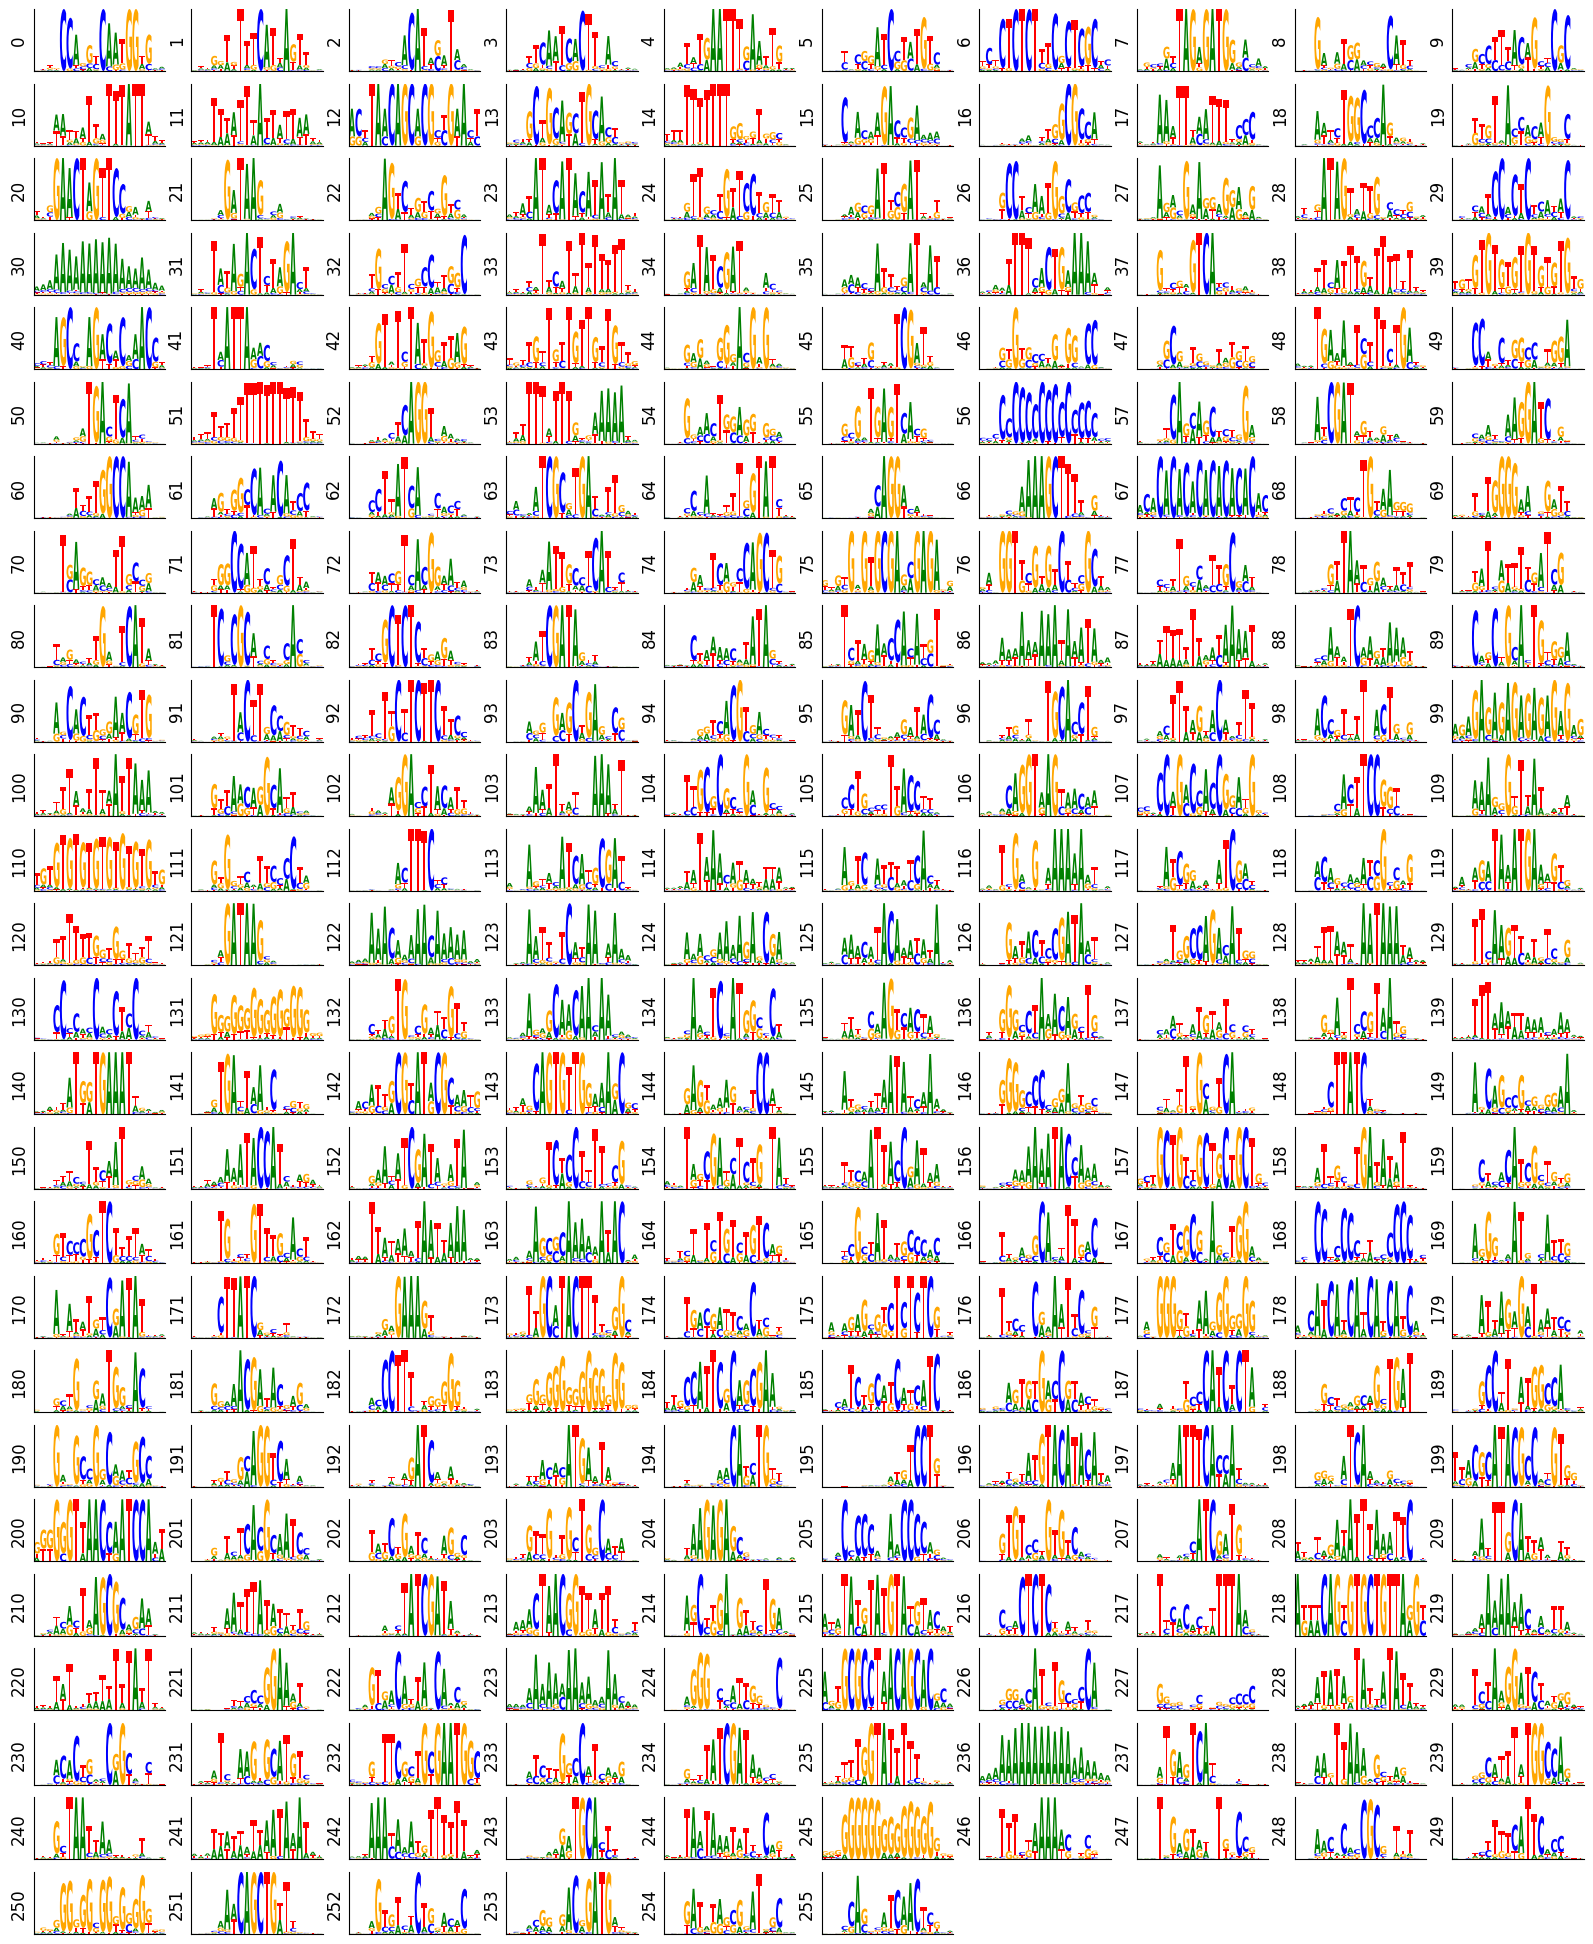

In [13]:
# interpret model
tuner.interpret_model(layer=3)

if(config['conv1_channel_weight'] == "softconv"):
        layer = 5
elif(config['conv1_channel_weight'] == "se"):
    layer = 8
else:
    layer = None
    print("Finished interpreting!")

In [19]:
save_path

'/home/chandana/projects/hominid_pipeline/experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/exponential/variations/variation_0'

Loading model and dataset!
Building model...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 249, 4)]     0           []                               
                                                                                                  
 pairwise_conv1d (PairwiseConv1  (None, 249, 256)    468736      ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 249, 256)     1024        ['pairwise_conv1d[0][0]']        
                                                                                                  
 conv1_activation (Activation)  (None, 249, 256)     0           ['conv1_bn[0][0]']           

 dense_15 (Dense)               (None, 1)            257         ['dropout_5[0][0]']              
                                                                                                  
 tf.concat (TFOpLambda)         (None, 2)            0           ['dense_7[0][0]',                
                                                                  'dense_15[0][0]']               
                                                                                                  
Total params: 3,298,114
Trainable params: 3,295,554
Non-trainable params: 2,560
__________________________________________________________________________________________________
None
Interpreting filters!
Making intermediate predictions...


  0%|                                                                                                                                                                                                                                  | 0/643 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  0%|▎                                                                                                                                                                                                                         | 1/643 [00:00<01:53,  5.65it/s]

2/2 [==============================] - 0s 2ms/step


  0%|█                                                                                                                                                                                                                         | 3/643 [00:00<01:04,  9.93it/s]

2/2 [==============================] - 0s 3ms/step


  1%|█▋                                                                                                                                                                                                                        | 5/643 [00:00<00:54, 11.61it/s]

2/2 [==============================] - 0s 2ms/step


  1%|██▎                                                                                                                                                                                                                       | 7/643 [00:00<00:50, 12.51it/s]

2/2 [==============================] - 0s 2ms/step


  1%|███                                                                                                                                                                                                                       | 9/643 [00:00<00:48, 13.16it/s]

2/2 [==============================] - 0s 3ms/step


  2%|███▋                                                                                                                                                                                                                     | 11/643 [00:00<00:46, 13.55it/s]

2/2 [==============================] - 0s 2ms/step


  2%|████▍                                                                                                                                                                                                                    | 13/643 [00:01<00:46, 13.67it/s]

2/2 [==============================] - 0s 3ms/step


  2%|█████                                                                                                                                                                                                                    | 15/643 [00:01<00:45, 13.69it/s]

2/2 [==============================] - 0s 2ms/step


  3%|█████▋                                                                                                                                                                                                                   | 17/643 [00:01<00:44, 13.94it/s]

2/2 [==============================] - 0s 2ms/step


  3%|██████▍                                                                                                                                                                                                                  | 19/643 [00:01<00:45, 13.86it/s]

2/2 [==============================] - 0s 3ms/step


  3%|███████                                                                                                                                                                                                                  | 21/643 [00:01<00:44, 14.01it/s]

2/2 [==============================] - 0s 2ms/step


  4%|███████▊                                                                                                                                                                                                                 | 23/643 [00:01<00:43, 14.17it/s]

2/2 [==============================] - 0s 2ms/step


  4%|████████▍                                                                                                                                                                                                                | 25/643 [00:01<00:43, 14.06it/s]

2/2 [==============================] - 0s 2ms/step


  4%|█████████                                                                                                                                                                                                                | 27/643 [00:02<00:44, 13.95it/s]

2/2 [==============================] - 0s 2ms/step


  5%|█████████▊                                                                                                                                                                                                               | 29/643 [00:02<00:43, 14.23it/s]

2/2 [==============================] - 0s 2ms/step


  5%|██████████▍                                                                                                                                                                                                              | 31/643 [00:02<00:42, 14.36it/s]

2/2 [==============================] - 0s 3ms/step


  5%|███████████▏                                                                                                                                                                                                             | 33/643 [00:02<00:42, 14.46it/s]

2/2 [==============================] - 0s 2ms/step


  5%|███████████▊                                                                                                                                                                                                             | 35/643 [00:02<00:43, 13.92it/s]

2/2 [==============================] - 0s 2ms/step


  6%|████████████▍                                                                                                                                                                                                            | 37/643 [00:02<00:42, 14.14it/s]

2/2 [==============================] - 0s 3ms/step


  6%|█████████████▏                                                                                                                                                                                                           | 39/643 [00:02<00:42, 14.36it/s]

2/2 [==============================] - 0s 3ms/step


  6%|█████████████▊                                                                                                                                                                                                           | 41/643 [00:02<00:41, 14.54it/s]

2/2 [==============================] - 0s 3ms/step


  7%|██████████████▌                                                                                                                                                                                                          | 43/643 [00:03<00:41, 14.49it/s]

2/2 [==============================] - 0s 2ms/step


  7%|███████████████▏                                                                                                                                                                                                         | 45/643 [00:03<00:41, 14.35it/s]

2/2 [==============================] - 0s 2ms/step


  7%|███████████████▊                                                                                                                                                                                                         | 47/643 [00:03<00:40, 14.59it/s]

2/2 [==============================] - 0s 2ms/step


  8%|████████████████▌                                                                                                                                                                                                        | 49/643 [00:03<00:40, 14.78it/s]

2/2 [==============================] - 0s 2ms/step


  8%|█████████████████▏                                                                                                                                                                                                       | 51/643 [00:03<00:39, 14.84it/s]

2/2 [==============================] - 0s 2ms/step


  8%|█████████████████▉                                                                                                                                                                                                       | 53/643 [00:03<00:39, 14.97it/s]

2/2 [==============================] - 0s 2ms/step


  9%|██████████████████▌                                                                                                                                                                                                      | 55/643 [00:03<00:39, 14.71it/s]

2/2 [==============================] - 0s 2ms/step


  9%|███████████████████▏                                                                                                                                                                                                     | 57/643 [00:04<00:40, 14.54it/s]

2/2 [==============================] - 0s 2ms/step


  9%|███████████████████▉                                                                                                                                                                                                     | 59/643 [00:04<00:39, 14.70it/s]

2/2 [==============================] - 0s 2ms/step


  9%|████████████████████▌                                                                                                                                                                                                    | 61/643 [00:04<00:39, 14.60it/s]

2/2 [==============================] - 0s 2ms/step


 10%|█████████████████████▎                                                                                                                                                                                                   | 63/643 [00:04<00:39, 14.67it/s]

2/2 [==============================] - 0s 3ms/step


 10%|█████████████████████▉                                                                                                                                                                                                   | 65/643 [00:04<00:40, 14.35it/s]

2/2 [==============================] - 0s 2ms/step


 10%|██████████████████████▌                                                                                                                                                                                                  | 67/643 [00:04<00:39, 14.55it/s]

2/2 [==============================] - 0s 2ms/step


 11%|███████████████████████▎                                                                                                                                                                                                 | 69/643 [00:04<00:38, 14.74it/s]

2/2 [==============================] - 0s 2ms/step


 11%|███████████████████████▉                                                                                                                                                                                                 | 71/643 [00:05<00:38, 14.90it/s]

2/2 [==============================] - 0s 2ms/step


 11%|████████████████████████▋                                                                                                                                                                                                | 73/643 [00:05<00:37, 15.06it/s]

2/2 [==============================] - 0s 2ms/step


 12%|█████████████████████████▎                                                                                                                                                                                               | 75/643 [00:05<00:38, 14.75it/s]

2/2 [==============================] - 0s 2ms/step


 12%|█████████████████████████▉                                                                                                                                                                                               | 77/643 [00:05<00:38, 14.88it/s]

2/2 [==============================] - 0s 2ms/step


 12%|██████████████████████████▋                                                                                                                                                                                              | 79/643 [00:05<00:37, 15.06it/s]

2/2 [==============================] - 0s 2ms/step


 13%|███████████████████████████▎                                                                                                                                                                                             | 81/643 [00:05<00:36, 15.21it/s]

2/2 [==============================] - 0s 2ms/step


 13%|████████████████████████████                                                                                                                                                                                             | 83/643 [00:05<00:36, 15.33it/s]

2/2 [==============================] - 0s 2ms/step


 13%|████████████████████████████▋                                                                                                                                                                                            | 85/643 [00:05<00:37, 15.06it/s]

2/2 [==============================] - 0s 2ms/step


 14%|█████████████████████████████▎                                                                                                                                                                                           | 87/643 [00:06<00:37, 14.80it/s]

2/2 [==============================] - 0s 2ms/step


 14%|██████████████████████████████                                                                                                                                                                                           | 89/643 [00:06<00:36, 14.98it/s]

2/2 [==============================] - 0s 2ms/step


 14%|██████████████████████████████▋                                                                                                                                                                                          | 91/643 [00:06<00:37, 14.90it/s]

2/2 [==============================] - 0s 2ms/step


 14%|███████████████████████████████▍                                                                                                                                                                                         | 93/643 [00:06<00:36, 15.01it/s]

2/2 [==============================] - 0s 2ms/step


 15%|████████████████████████████████                                                                                                                                                                                         | 95/643 [00:06<00:36, 14.89it/s]

2/2 [==============================] - 0s 2ms/step


 15%|████████████████████████████████▋                                                                                                                                                                                        | 97/643 [00:06<00:36, 14.96it/s]

2/2 [==============================] - 0s 2ms/step


 15%|█████████████████████████████████▍                                                                                                                                                                                       | 99/643 [00:06<00:35, 15.19it/s]

2/2 [==============================] - 0s 2ms/step


 16%|█████████████████████████████████▉                                                                                                                                                                                      | 101/643 [00:07<00:35, 15.30it/s]

2/2 [==============================] - 0s 2ms/step


 16%|██████████████████████████████████▌                                                                                                                                                                                     | 103/643 [00:07<00:35, 15.31it/s]

2/2 [==============================] - 0s 2ms/step


 16%|███████████████████████████████████▎                                                                                                                                                                                    | 105/643 [00:07<00:36, 14.85it/s]

2/2 [==============================] - 0s 2ms/step


 17%|███████████████████████████████████▉                                                                                                                                                                                    | 107/643 [00:07<00:35, 14.93it/s]

2/2 [==============================] - 0s 3ms/step


 17%|████████████████████████████████████▌                                                                                                                                                                                   | 109/643 [00:07<00:35, 15.00it/s]

2/2 [==============================] - 0s 2ms/step


 17%|█████████████████████████████████████▎                                                                                                                                                                                  | 111/643 [00:07<00:34, 15.27it/s]

2/2 [==============================] - 0s 2ms/step


 18%|█████████████████████████████████████▉                                                                                                                                                                                  | 113/643 [00:07<00:34, 15.32it/s]

2/2 [==============================] - 0s 2ms/step


 18%|██████████████████████████████████████▋                                                                                                                                                                                 | 115/643 [00:07<00:34, 15.12it/s]

2/2 [==============================] - 0s 2ms/step


 18%|███████████████████████████████████████▎                                                                                                                                                                                | 117/643 [00:08<00:35, 15.00it/s]

2/2 [==============================] - 0s 2ms/step


 19%|███████████████████████████████████████▉                                                                                                                                                                                | 119/643 [00:08<00:34, 15.15it/s]

2/2 [==============================] - 0s 2ms/step


 19%|████████████████████████████████████████▋                                                                                                                                                                               | 121/643 [00:08<00:33, 15.37it/s]

2/2 [==============================] - 0s 2ms/step


 19%|█████████████████████████████████████████▎                                                                                                                                                                              | 123/643 [00:08<00:33, 15.48it/s]

2/2 [==============================] - 0s 2ms/step


 19%|█████████████████████████████████████████▉                                                                                                                                                                              | 125/643 [00:08<00:34, 15.17it/s]

2/2 [==============================] - 0s 2ms/step


 20%|██████████████████████████████████████████▋                                                                                                                                                                             | 127/643 [00:08<00:33, 15.30it/s]

2/2 [==============================] - 0s 2ms/step


 20%|███████████████████████████████████████████▎                                                                                                                                                                            | 129/643 [00:08<00:33, 15.37it/s]

2/2 [==============================] - 0s 2ms/step


 20%|████████████████████████████████████████████                                                                                                                                                                            | 131/643 [00:08<00:32, 15.52it/s]

2/2 [==============================] - 0s 2ms/step


 21%|████████████████████████████████████████████▋                                                                                                                                                                           | 133/643 [00:09<00:32, 15.60it/s]

2/2 [==============================] - 0s 2ms/step


 21%|█████████████████████████████████████████████▎                                                                                                                                                                          | 135/643 [00:09<00:33, 15.26it/s]

2/2 [==============================] - 0s 3ms/step


 21%|██████████████████████████████████████████████                                                                                                                                                                          | 137/643 [00:09<00:32, 15.36it/s]

2/2 [==============================] - 0s 2ms/step


 22%|██████████████████████████████████████████████▋                                                                                                                                                                         | 139/643 [00:09<00:32, 15.48it/s]

2/2 [==============================] - 0s 2ms/step


 22%|███████████████████████████████████████████████▎                                                                                                                                                                        | 141/643 [00:09<00:32, 15.42it/s]

2/2 [==============================] - 0s 2ms/step


 22%|████████████████████████████████████████████████                                                                                                                                                                        | 143/643 [00:09<00:32, 15.53it/s]

2/2 [==============================] - 0s 2ms/step


 23%|████████████████████████████████████████████████▋                                                                                                                                                                       | 145/643 [00:09<00:32, 15.21it/s]

2/2 [==============================] - 0s 2ms/step


 23%|█████████████████████████████████████████████████▍                                                                                                                                                                      | 147/643 [00:10<00:32, 15.32it/s]

2/2 [==============================] - 0s 3ms/step


 23%|██████████████████████████████████████████████████                                                                                                                                                                      | 149/643 [00:10<00:32, 15.43it/s]

2/2 [==============================] - 0s 2ms/step


 23%|██████████████████████████████████████████████████▋                                                                                                                                                                     | 151/643 [00:10<00:32, 15.29it/s]

2/2 [==============================] - 0s 3ms/step


 24%|███████████████████████████████████████████████████▍                                                                                                                                                                    | 153/643 [00:10<00:32, 15.19it/s]

2/2 [==============================] - 0s 2ms/step


 24%|████████████████████████████████████████████████████                                                                                                                                                                    | 155/643 [00:10<00:32, 14.85it/s]

2/2 [==============================] - 0s 2ms/step


 24%|████████████████████████████████████████████████████▋                                                                                                                                                                   | 157/643 [00:10<00:32, 14.87it/s]

2/2 [==============================] - 0s 2ms/step


 25%|█████████████████████████████████████████████████████▍                                                                                                                                                                  | 159/643 [00:10<00:32, 15.03it/s]

2/2 [==============================] - 0s 3ms/step


 25%|██████████████████████████████████████████████████████                                                                                                                                                                  | 161/643 [00:10<00:32, 14.97it/s]

2/2 [==============================] - 0s 2ms/step


 25%|██████████████████████████████████████████████████████▊                                                                                                                                                                 | 163/643 [00:11<00:31, 15.06it/s]

2/2 [==============================] - 0s 2ms/step


 26%|███████████████████████████████████████████████████████▍                                                                                                                                                                | 165/643 [00:11<00:31, 14.96it/s]

2/2 [==============================] - 0s 2ms/step


 26%|████████████████████████████████████████████████████████                                                                                                                                                                | 167/643 [00:11<00:35, 13.34it/s]

2/2 [==============================] - 0s 2ms/step


 26%|████████████████████████████████████████████████████████▊                                                                                                                                                               | 169/643 [00:11<00:34, 13.93it/s]

2/2 [==============================] - 0s 2ms/step


 27%|█████████████████████████████████████████████████████████▍                                                                                                                                                              | 171/643 [00:11<00:33, 14.28it/s]

2/2 [==============================] - 0s 2ms/step


 27%|██████████████████████████████████████████████████████████                                                                                                                                                              | 173/643 [00:11<00:32, 14.64it/s]

2/2 [==============================] - 0s 3ms/step


 27%|██████████████████████████████████████████████████████████▊                                                                                                                                                             | 175/643 [00:11<00:32, 14.41it/s]

2/2 [==============================] - 0s 2ms/step


 28%|███████████████████████████████████████████████████████████▍                                                                                                                                                            | 177/643 [00:12<00:33, 13.87it/s]

2/2 [==============================] - 0s 2ms/step


 28%|████████████████████████████████████████████████████████████▏                                                                                                                                                           | 179/643 [00:12<00:32, 14.35it/s]

2/2 [==============================] - 0s 2ms/step


 28%|████████████████████████████████████████████████████████████▊                                                                                                                                                           | 181/643 [00:12<00:31, 14.72it/s]

2/2 [==============================] - 0s 2ms/step


 28%|█████████████████████████████████████████████████████████████▍                                                                                                                                                          | 183/643 [00:12<00:30, 14.90it/s]

2/2 [==============================] - 0s 2ms/step


 29%|██████████████████████████████████████████████████████████████▏                                                                                                                                                         | 185/643 [00:12<00:30, 14.79it/s]

2/2 [==============================] - 0s 2ms/step


 29%|██████████████████████████████████████████████████████████████▊                                                                                                                                                         | 187/643 [00:12<00:30, 14.89it/s]

2/2 [==============================] - 0s 3ms/step


 29%|███████████████████████████████████████████████████████████████▍                                                                                                                                                        | 189/643 [00:12<00:30, 14.86it/s]

2/2 [==============================] - 0s 2ms/step


 30%|████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 191/643 [00:13<00:30, 14.63it/s]

2/2 [==============================] - 0s 3ms/step


 30%|████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 193/643 [00:13<00:30, 14.69it/s]

2/2 [==============================] - 0s 2ms/step


 30%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 195/643 [00:13<00:30, 14.62it/s]

2/2 [==============================] - 0s 2ms/step


 31%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 197/643 [00:13<00:30, 14.85it/s]

2/2 [==============================] - 0s 2ms/step


 31%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                     | 199/643 [00:13<00:30, 14.79it/s]

2/2 [==============================] - 0s 2ms/step


 31%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 201/643 [00:13<00:29, 14.98it/s]

2/2 [==============================] - 0s 2ms/step


 32%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 203/643 [00:13<00:29, 15.02it/s]

2/2 [==============================] - 0s 2ms/step


 32%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 205/643 [00:13<00:30, 14.57it/s]

2/2 [==============================] - 0s 2ms/step


 32%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 207/643 [00:14<00:29, 14.85it/s]

2/2 [==============================] - 0s 2ms/step


 33%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 209/643 [00:14<00:28, 14.98it/s]

2/2 [==============================] - 0s 3ms/step


 33%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 211/643 [00:14<00:28, 15.18it/s]

2/2 [==============================] - 0s 2ms/step


 33%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 213/643 [00:14<00:28, 15.21it/s]

2/2 [==============================] - 0s 2ms/step


 33%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 215/643 [00:14<00:28, 14.97it/s]

2/2 [==============================] - 0s 2ms/step


 34%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 217/643 [00:14<00:28, 15.18it/s]

2/2 [==============================] - 0s 2ms/step


 34%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 219/643 [00:14<00:27, 15.31it/s]

2/2 [==============================] - 0s 2ms/step


 34%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 221/643 [00:15<00:27, 15.16it/s]

2/2 [==============================] - 0s 2ms/step


 35%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 223/643 [00:15<00:27, 15.21it/s]

2/2 [==============================] - 0s 3ms/step


 35%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 225/643 [00:15<00:27, 14.96it/s]

2/2 [==============================] - 0s 2ms/step


 35%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 227/643 [00:15<00:27, 15.17it/s]

2/2 [==============================] - 0s 2ms/step


 36%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 229/643 [00:15<00:26, 15.34it/s]

2/2 [==============================] - 0s 2ms/step


 36%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 231/643 [00:15<00:26, 15.44it/s]

2/2 [==============================] - 0s 2ms/step


 36%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 233/643 [00:15<00:26, 15.51it/s]

2/2 [==============================] - 0s 2ms/step


 37%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 235/643 [00:15<00:27, 14.94it/s]

2/2 [==============================] - 0s 2ms/step


 37%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 237/643 [00:16<00:26, 15.15it/s]

2/2 [==============================] - 0s 2ms/step


 37%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 239/643 [00:16<00:26, 15.19it/s]

2/2 [==============================] - 0s 2ms/step


 37%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 241/643 [00:16<00:27, 14.82it/s]

2/2 [==============================] - 0s 2ms/step


 38%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 243/643 [00:16<00:26, 14.97it/s]

2/2 [==============================] - 0s 3ms/step


 38%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 245/643 [00:16<00:27, 14.61it/s]

2/2 [==============================] - 0s 2ms/step


 38%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 247/643 [00:16<00:26, 14.81it/s]

2/2 [==============================] - 0s 2ms/step


 39%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 249/643 [00:16<00:26, 15.09it/s]

2/2 [==============================] - 0s 2ms/step


 39%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 251/643 [00:17<00:25, 15.29it/s]

2/2 [==============================] - 0s 2ms/step


 39%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 253/643 [00:17<00:31, 12.48it/s]

2/2 [==============================] - 0s 2ms/step


 40%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 255/643 [00:17<00:30, 12.82it/s]

2/2 [==============================] - 0s 2ms/step


 40%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 257/643 [00:17<00:28, 13.54it/s]

2/2 [==============================] - 0s 2ms/step


 40%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 259/643 [00:17<00:27, 14.13it/s]

2/2 [==============================] - 0s 2ms/step


 41%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 261/643 [00:17<00:26, 14.45it/s]

2/2 [==============================] - 0s 3ms/step


 41%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 263/643 [00:17<00:25, 14.81it/s]

2/2 [==============================] - 0s 3ms/step


 41%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 265/643 [00:18<00:25, 14.67it/s]

2/2 [==============================] - 0s 2ms/step


 42%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 267/643 [00:18<00:25, 14.87it/s]

2/2 [==============================] - 0s 2ms/step


 42%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 269/643 [00:18<00:24, 15.09it/s]

2/2 [==============================] - 0s 2ms/step


 42%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 271/643 [00:18<00:24, 15.21it/s]

2/2 [==============================] - 0s 3ms/step


 42%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 273/643 [00:18<00:24, 15.38it/s]

2/2 [==============================] - 0s 3ms/step


 43%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 275/643 [00:18<00:24, 15.06it/s]

2/2 [==============================] - 0s 2ms/step


 43%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 277/643 [00:18<00:24, 15.22it/s]

2/2 [==============================] - 0s 3ms/step


 43%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 279/643 [00:18<00:23, 15.25it/s]

2/2 [==============================] - 0s 2ms/step


 44%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 281/643 [00:19<00:24, 15.03it/s]

2/2 [==============================] - 0s 3ms/step


 44%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 283/643 [00:19<00:23, 15.19it/s]

2/2 [==============================] - 0s 2ms/step


 44%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 285/643 [00:19<00:23, 14.95it/s]

2/2 [==============================] - 0s 2ms/step


 45%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 287/643 [00:19<00:23, 14.89it/s]

2/2 [==============================] - 0s 3ms/step


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 289/643 [00:19<00:23, 14.84it/s]

2/2 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 291/643 [00:19<00:23, 14.91it/s]

2/2 [==============================] - 0s 2ms/step


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 293/643 [00:19<00:23, 15.18it/s]

2/2 [==============================] - 0s 3ms/step


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 295/643 [00:20<00:23, 14.91it/s]

2/2 [==============================] - 0s 3ms/step


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 297/643 [00:20<00:22, 15.08it/s]

2/2 [==============================] - 0s 2ms/step


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 299/643 [00:20<00:22, 15.06it/s]

2/2 [==============================] - 0s 2ms/step


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 301/643 [00:20<00:22, 15.06it/s]

2/2 [==============================] - 0s 2ms/step


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 303/643 [00:20<00:22, 14.91it/s]

2/2 [==============================] - 0s 3ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 305/643 [00:20<00:23, 14.33it/s]

2/2 [==============================] - 0s 3ms/step


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 307/643 [00:20<00:23, 14.56it/s]

2/2 [==============================] - 0s 2ms/step


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 309/643 [00:20<00:22, 14.78it/s]

2/2 [==============================] - 0s 2ms/step


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 311/643 [00:21<00:22, 14.98it/s]

2/2 [==============================] - 0s 3ms/step


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 313/643 [00:21<00:22, 14.86it/s]

2/2 [==============================] - 0s 3ms/step


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 315/643 [00:21<00:22, 14.69it/s]

2/2 [==============================] - 0s 3ms/step


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 317/643 [00:21<00:21, 14.92it/s]

2/2 [==============================] - 0s 2ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 319/643 [00:21<00:21, 14.97it/s]

2/2 [==============================] - 0s 2ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 321/643 [00:21<00:21, 14.99it/s]

2/2 [==============================] - 0s 3ms/step


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 323/643 [00:21<00:21, 15.17it/s]

2/2 [==============================] - 0s 2ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 325/643 [00:22<00:21, 14.63it/s]

2/2 [==============================] - 0s 2ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 327/643 [00:22<00:24, 13.13it/s]

2/2 [==============================] - 0s 2ms/step


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 329/643 [00:22<00:22, 13.68it/s]

2/2 [==============================] - 0s 2ms/step


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 331/643 [00:22<00:22, 14.12it/s]

2/2 [==============================] - 0s 3ms/step


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 333/643 [00:22<00:21, 14.43it/s]

2/2 [==============================] - 0s 3ms/step


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 335/643 [00:22<00:21, 14.24it/s]

2/2 [==============================] - 0s 3ms/step


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 337/643 [00:22<00:21, 14.41it/s]

2/2 [==============================] - 0s 2ms/step


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 339/643 [00:23<00:20, 14.64it/s]

2/2 [==============================] - 0s 3ms/step


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 341/643 [00:23<00:20, 14.87it/s]

2/2 [==============================] - 0s 2ms/step


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 343/643 [00:23<00:19, 15.05it/s]

2/2 [==============================] - 0s 2ms/step


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 345/643 [00:23<00:20, 14.87it/s]

2/2 [==============================] - 0s 2ms/step


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 347/643 [00:23<00:19, 14.90it/s]

2/2 [==============================] - 0s 2ms/step


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 349/643 [00:23<00:19, 15.12it/s]

2/2 [==============================] - 0s 3ms/step


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 351/643 [00:23<00:19, 15.27it/s]

2/2 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 353/643 [00:23<00:18, 15.36it/s]

2/2 [==============================] - 0s 2ms/step


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 355/643 [00:24<00:19, 14.87it/s]

2/2 [==============================] - 0s 2ms/step


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 357/643 [00:24<00:19, 14.88it/s]

2/2 [==============================] - 0s 2ms/step


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 359/643 [00:24<00:19, 14.74it/s]

2/2 [==============================] - 0s 2ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 361/643 [00:24<00:18, 14.88it/s]

2/2 [==============================] - 0s 2ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 363/643 [00:24<00:18, 14.90it/s]

2/2 [==============================] - 0s 3ms/step


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 365/643 [00:24<00:19, 14.59it/s]

2/2 [==============================] - 0s 3ms/step


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 367/643 [00:24<00:18, 14.77it/s]

2/2 [==============================] - 0s 2ms/step


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 369/643 [00:25<00:18, 14.95it/s]

2/2 [==============================] - 0s 3ms/step


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 371/643 [00:25<00:18, 15.00it/s]

2/2 [==============================] - 0s 2ms/step


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 373/643 [00:25<00:17, 15.17it/s]

2/2 [==============================] - 0s 2ms/step


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 375/643 [00:25<00:17, 14.92it/s]

2/2 [==============================] - 0s 2ms/step


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 377/643 [00:25<00:17, 14.90it/s]

2/2 [==============================] - 0s 2ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 379/643 [00:25<00:17, 15.12it/s]

2/2 [==============================] - 0s 2ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 381/643 [00:25<00:17, 15.30it/s]

2/2 [==============================] - 0s 2ms/step


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 383/643 [00:25<00:17, 15.22it/s]

2/2 [==============================] - 0s 2ms/step


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 385/643 [00:26<00:17, 14.83it/s]

2/2 [==============================] - 0s 2ms/step


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 387/643 [00:26<00:17, 14.76it/s]

2/2 [==============================] - 0s 2ms/step


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 389/643 [00:26<00:16, 14.97it/s]

2/2 [==============================] - 0s 2ms/step


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 391/643 [00:26<00:16, 15.09it/s]

2/2 [==============================] - 0s 2ms/step


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 393/643 [00:26<00:16, 15.15it/s]

2/2 [==============================] - 0s 3ms/step


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 395/643 [00:26<00:16, 14.84it/s]

2/2 [==============================] - 0s 2ms/step


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 397/643 [00:26<00:16, 14.99it/s]

2/2 [==============================] - 0s 2ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 399/643 [00:27<00:16, 15.09it/s]

2/2 [==============================] - 0s 3ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 401/643 [00:27<00:16, 15.04it/s]

2/2 [==============================] - 0s 7ms/step


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 403/643 [00:27<00:16, 14.33it/s]

2/2 [==============================] - 0s 2ms/step


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 405/643 [00:27<00:16, 14.20it/s]

2/2 [==============================] - 0s 2ms/step


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 407/643 [00:27<00:16, 14.39it/s]

2/2 [==============================] - 0s 2ms/step


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 409/643 [00:27<00:16, 14.62it/s]

2/2 [==============================] - 0s 2ms/step


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 411/643 [00:27<00:15, 14.88it/s]

2/2 [==============================] - 0s 2ms/step


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 413/643 [00:28<00:15, 14.99it/s]

2/2 [==============================] - 0s 3ms/step


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 415/643 [00:28<00:15, 14.67it/s]

2/2 [==============================] - 0s 3ms/step


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 417/643 [00:28<00:15, 14.52it/s]

2/2 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 419/643 [00:28<00:15, 14.37it/s]

2/2 [==============================] - 0s 3ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 421/643 [00:28<00:15, 14.64it/s]

2/2 [==============================] - 0s 2ms/step


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 423/643 [00:28<00:14, 14.92it/s]

2/2 [==============================] - 0s 2ms/step


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 425/643 [00:28<00:14, 14.70it/s]

2/2 [==============================] - 0s 2ms/step


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 427/643 [00:28<00:14, 14.91it/s]

2/2 [==============================] - 0s 3ms/step


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 429/643 [00:29<00:14, 15.12it/s]

2/2 [==============================] - 0s 2ms/step


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 431/643 [00:29<00:13, 15.32it/s]

2/2 [==============================] - 0s 3ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 433/643 [00:29<00:13, 15.17it/s]

2/2 [==============================] - 0s 2ms/step


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 435/643 [00:29<00:13, 14.97it/s]

2/2 [==============================] - 0s 3ms/step


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 437/643 [00:29<00:13, 14.90it/s]

2/2 [==============================] - 0s 2ms/step


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 439/643 [00:29<00:13, 14.78it/s]

2/2 [==============================] - 0s 2ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 441/643 [00:29<00:13, 15.05it/s]

2/2 [==============================] - 0s 2ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 443/643 [00:30<00:13, 15.11it/s]

2/2 [==============================] - 0s 2ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 445/643 [00:30<00:13, 14.93it/s]

2/2 [==============================] - 0s 2ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 447/643 [00:30<00:13, 15.08it/s]

2/2 [==============================] - 0s 3ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 449/643 [00:30<00:12, 15.13it/s]

2/2 [==============================] - 0s 3ms/step


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 451/643 [00:30<00:12, 14.91it/s]

2/2 [==============================] - 0s 2ms/step


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 453/643 [00:30<00:12, 14.93it/s]

2/2 [==============================] - 0s 2ms/step


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 455/643 [00:30<00:12, 14.59it/s]

2/2 [==============================] - 0s 2ms/step


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 457/643 [00:30<00:12, 14.87it/s]

2/2 [==============================] - 0s 2ms/step


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 459/643 [00:31<00:12, 15.11it/s]

2/2 [==============================] - 0s 2ms/step


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 461/643 [00:31<00:11, 15.27it/s]

2/2 [==============================] - 0s 3ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 463/643 [00:31<00:11, 15.27it/s]

2/2 [==============================] - 0s 2ms/step


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 465/643 [00:31<00:11, 15.05it/s]

2/2 [==============================] - 0s 2ms/step


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 467/643 [00:31<00:11, 15.14it/s]

2/2 [==============================] - 0s 3ms/step


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 469/643 [00:31<00:11, 15.25it/s]

2/2 [==============================] - 0s 3ms/step


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 471/643 [00:31<00:11, 15.33it/s]

2/2 [==============================] - 0s 2ms/step


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 473/643 [00:32<00:11, 15.37it/s]

2/2 [==============================] - 0s 3ms/step


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 475/643 [00:32<00:11, 14.76it/s]

2/2 [==============================] - 0s 3ms/step


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 477/643 [00:32<00:13, 12.07it/s]

2/2 [==============================] - 0s 3ms/step


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 479/643 [00:32<00:12, 12.85it/s]

2/2 [==============================] - 0s 2ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 481/643 [00:32<00:12, 13.32it/s]

2/2 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 483/643 [00:32<00:11, 13.50it/s]

2/2 [==============================] - 0s 3ms/step


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 485/643 [00:32<00:11, 13.62it/s]

2/2 [==============================] - 0s 2ms/step


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 487/643 [00:33<00:11, 14.16it/s]

2/2 [==============================] - 0s 3ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 489/643 [00:33<00:10, 14.25it/s]

2/2 [==============================] - 0s 3ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 491/643 [00:33<00:10, 14.60it/s]

2/2 [==============================] - 0s 2ms/step


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 493/643 [00:33<00:10, 14.87it/s]

2/2 [==============================] - 0s 2ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 495/643 [00:33<00:10, 14.58it/s]

2/2 [==============================] - 0s 2ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 497/643 [00:33<00:09, 14.86it/s]

2/2 [==============================] - 0s 2ms/step


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 499/643 [00:33<00:09, 15.06it/s]

2/2 [==============================] - 0s 2ms/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 501/643 [00:34<00:09, 15.07it/s]

2/2 [==============================] - 0s 2ms/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 503/643 [00:34<00:09, 14.94it/s]

2/2 [==============================] - 0s 3ms/step


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 505/643 [00:34<00:09, 14.63it/s]

2/2 [==============================] - 0s 3ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 507/643 [00:34<00:09, 14.53it/s]

2/2 [==============================] - 0s 2ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 509/643 [00:34<00:09, 14.84it/s]

2/2 [==============================] - 0s 2ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 511/643 [00:34<00:08, 14.99it/s]

2/2 [==============================] - 0s 2ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 513/643 [00:34<00:08, 15.04it/s]

2/2 [==============================] - 0s 2ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 515/643 [00:34<00:08, 14.87it/s]

2/2 [==============================] - 0s 3ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 517/643 [00:35<00:08, 14.98it/s]

2/2 [==============================] - 0s 2ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 519/643 [00:35<00:08, 15.00it/s]

2/2 [==============================] - 0s 2ms/step


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 521/643 [00:35<00:08, 15.09it/s]

2/2 [==============================] - 0s 3ms/step


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 523/643 [00:35<00:07, 15.22it/s]

2/2 [==============================] - 0s 2ms/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 525/643 [00:35<00:07, 14.93it/s]

2/2 [==============================] - 0s 3ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 527/643 [00:35<00:07, 14.59it/s]

2/2 [==============================] - 0s 3ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 529/643 [00:35<00:07, 14.61it/s]

2/2 [==============================] - 0s 3ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 531/643 [00:36<00:07, 14.73it/s]

2/2 [==============================] - 0s 2ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 533/643 [00:36<00:07, 14.82it/s]

2/2 [==============================] - 0s 2ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 535/643 [00:36<00:07, 14.45it/s]

2/2 [==============================] - 0s 3ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 537/643 [00:36<00:07, 14.61it/s]

2/2 [==============================] - 0s 2ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 539/643 [00:36<00:07, 14.68it/s]

2/2 [==============================] - 0s 2ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 541/643 [00:36<00:06, 14.84it/s]

2/2 [==============================] - 0s 3ms/step


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 543/643 [00:36<00:06, 14.95it/s]

2/2 [==============================] - 0s 3ms/step


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 545/643 [00:36<00:06, 14.62it/s]

2/2 [==============================] - 0s 2ms/step


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 547/643 [00:37<00:06, 14.78it/s]

2/2 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 549/643 [00:37<00:06, 14.83it/s]

2/2 [==============================] - 0s 3ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 551/643 [00:37<00:06, 14.74it/s]

2/2 [==============================] - 0s 2ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 553/643 [00:37<00:06, 14.68it/s]

2/2 [==============================] - 0s 3ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 555/643 [00:37<00:06, 14.28it/s]

2/2 [==============================] - 0s 3ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 557/643 [00:37<00:06, 14.28it/s]

2/2 [==============================] - 0s 2ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 559/643 [00:37<00:05, 14.56it/s]

2/2 [==============================] - 0s 3ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 561/643 [00:38<00:05, 14.60it/s]

2/2 [==============================] - 0s 3ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 563/643 [00:38<00:05, 14.76it/s]

2/2 [==============================] - 0s 2ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 565/643 [00:38<00:05, 14.66it/s]

2/2 [==============================] - 0s 2ms/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 567/643 [00:38<00:05, 14.81it/s]

2/2 [==============================] - 0s 3ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 569/643 [00:38<00:04, 14.84it/s]

2/2 [==============================] - 0s 3ms/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 571/643 [00:38<00:04, 15.09it/s]

2/2 [==============================] - 0s 3ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 573/643 [00:38<00:04, 15.19it/s]

2/2 [==============================] - 0s 2ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 575/643 [00:39<00:04, 14.95it/s]

2/2 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 577/643 [00:39<00:04, 15.03it/s]

2/2 [==============================] - 0s 3ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 579/643 [00:39<00:04, 14.98it/s]

2/2 [==============================] - 0s 3ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 581/643 [00:39<00:04, 15.14it/s]

2/2 [==============================] - 0s 2ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 583/643 [00:39<00:03, 15.26it/s]

2/2 [==============================] - 0s 2ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 585/643 [00:39<00:03, 14.97it/s]

2/2 [==============================] - 0s 2ms/step


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 587/643 [00:39<00:03, 15.06it/s]

2/2 [==============================] - 0s 2ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 589/643 [00:39<00:03, 15.07it/s]

2/2 [==============================] - 0s 2ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 591/643 [00:40<00:03, 15.22it/s]

2/2 [==============================] - 0s 2ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 593/643 [00:40<00:03, 15.39it/s]

2/2 [==============================] - 0s 2ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 595/643 [00:40<00:03, 15.04it/s]

2/2 [==============================] - 0s 3ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 597/643 [00:40<00:03, 15.12it/s]

2/2 [==============================] - 0s 3ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 599/643 [00:40<00:02, 15.01it/s]

2/2 [==============================] - 0s 2ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 601/643 [00:40<00:02, 15.08it/s]

2/2 [==============================] - 0s 2ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 603/643 [00:40<00:02, 15.02it/s]

2/2 [==============================] - 0s 2ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 605/643 [00:41<00:02, 14.42it/s]

2/2 [==============================] - 0s 2ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 607/643 [00:41<00:02, 14.57it/s]

2/2 [==============================] - 0s 2ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 609/643 [00:41<00:02, 14.61it/s]

2/2 [==============================] - 0s 3ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 611/643 [00:41<00:02, 14.91it/s]

2/2 [==============================] - 0s 2ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 613/643 [00:41<00:01, 15.15it/s]

2/2 [==============================] - 0s 3ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 615/643 [00:41<00:01, 14.76it/s]

2/2 [==============================] - 0s 2ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 617/643 [00:41<00:01, 14.99it/s]

2/2 [==============================] - 0s 3ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 619/643 [00:41<00:01, 14.96it/s]

2/2 [==============================] - 0s 3ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 621/643 [00:42<00:01, 14.99it/s]

2/2 [==============================] - 0s 3ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 623/643 [00:42<00:01, 14.99it/s]

2/2 [==============================] - 0s 2ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 625/643 [00:42<00:01, 12.47it/s]

2/2 [==============================] - 0s 3ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 627/643 [00:42<00:01, 13.24it/s]

2/2 [==============================] - 0s 2ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 629/643 [00:42<00:01, 13.81it/s]

2/2 [==============================] - 0s 2ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 631/643 [00:42<00:00, 14.27it/s]

2/2 [==============================] - 0s 2ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 633/643 [00:42<00:00, 14.65it/s]

2/2 [==============================] - 0s 3ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 635/643 [00:43<00:00, 14.51it/s]

2/2 [==============================] - 0s 3ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 637/643 [00:43<00:00, 14.49it/s]

2/2 [==============================] - 0s 3ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 639/643 [00:43<00:00, 14.53it/s]

2/2 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 641/643 [00:43<00:00, 14.31it/s]

2/2 [==============================] - 0s 3ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 643/643 [00:43<00:00, 14.73it/s]


Now removing the predictions file!
Calculating filter activations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:39<00:00,  6.45it/s]


Learned filters : empty filters = 256 : 256
Writing output for RSAT...
Loading filters...
Plotting filters...
Finished interpreting filters!


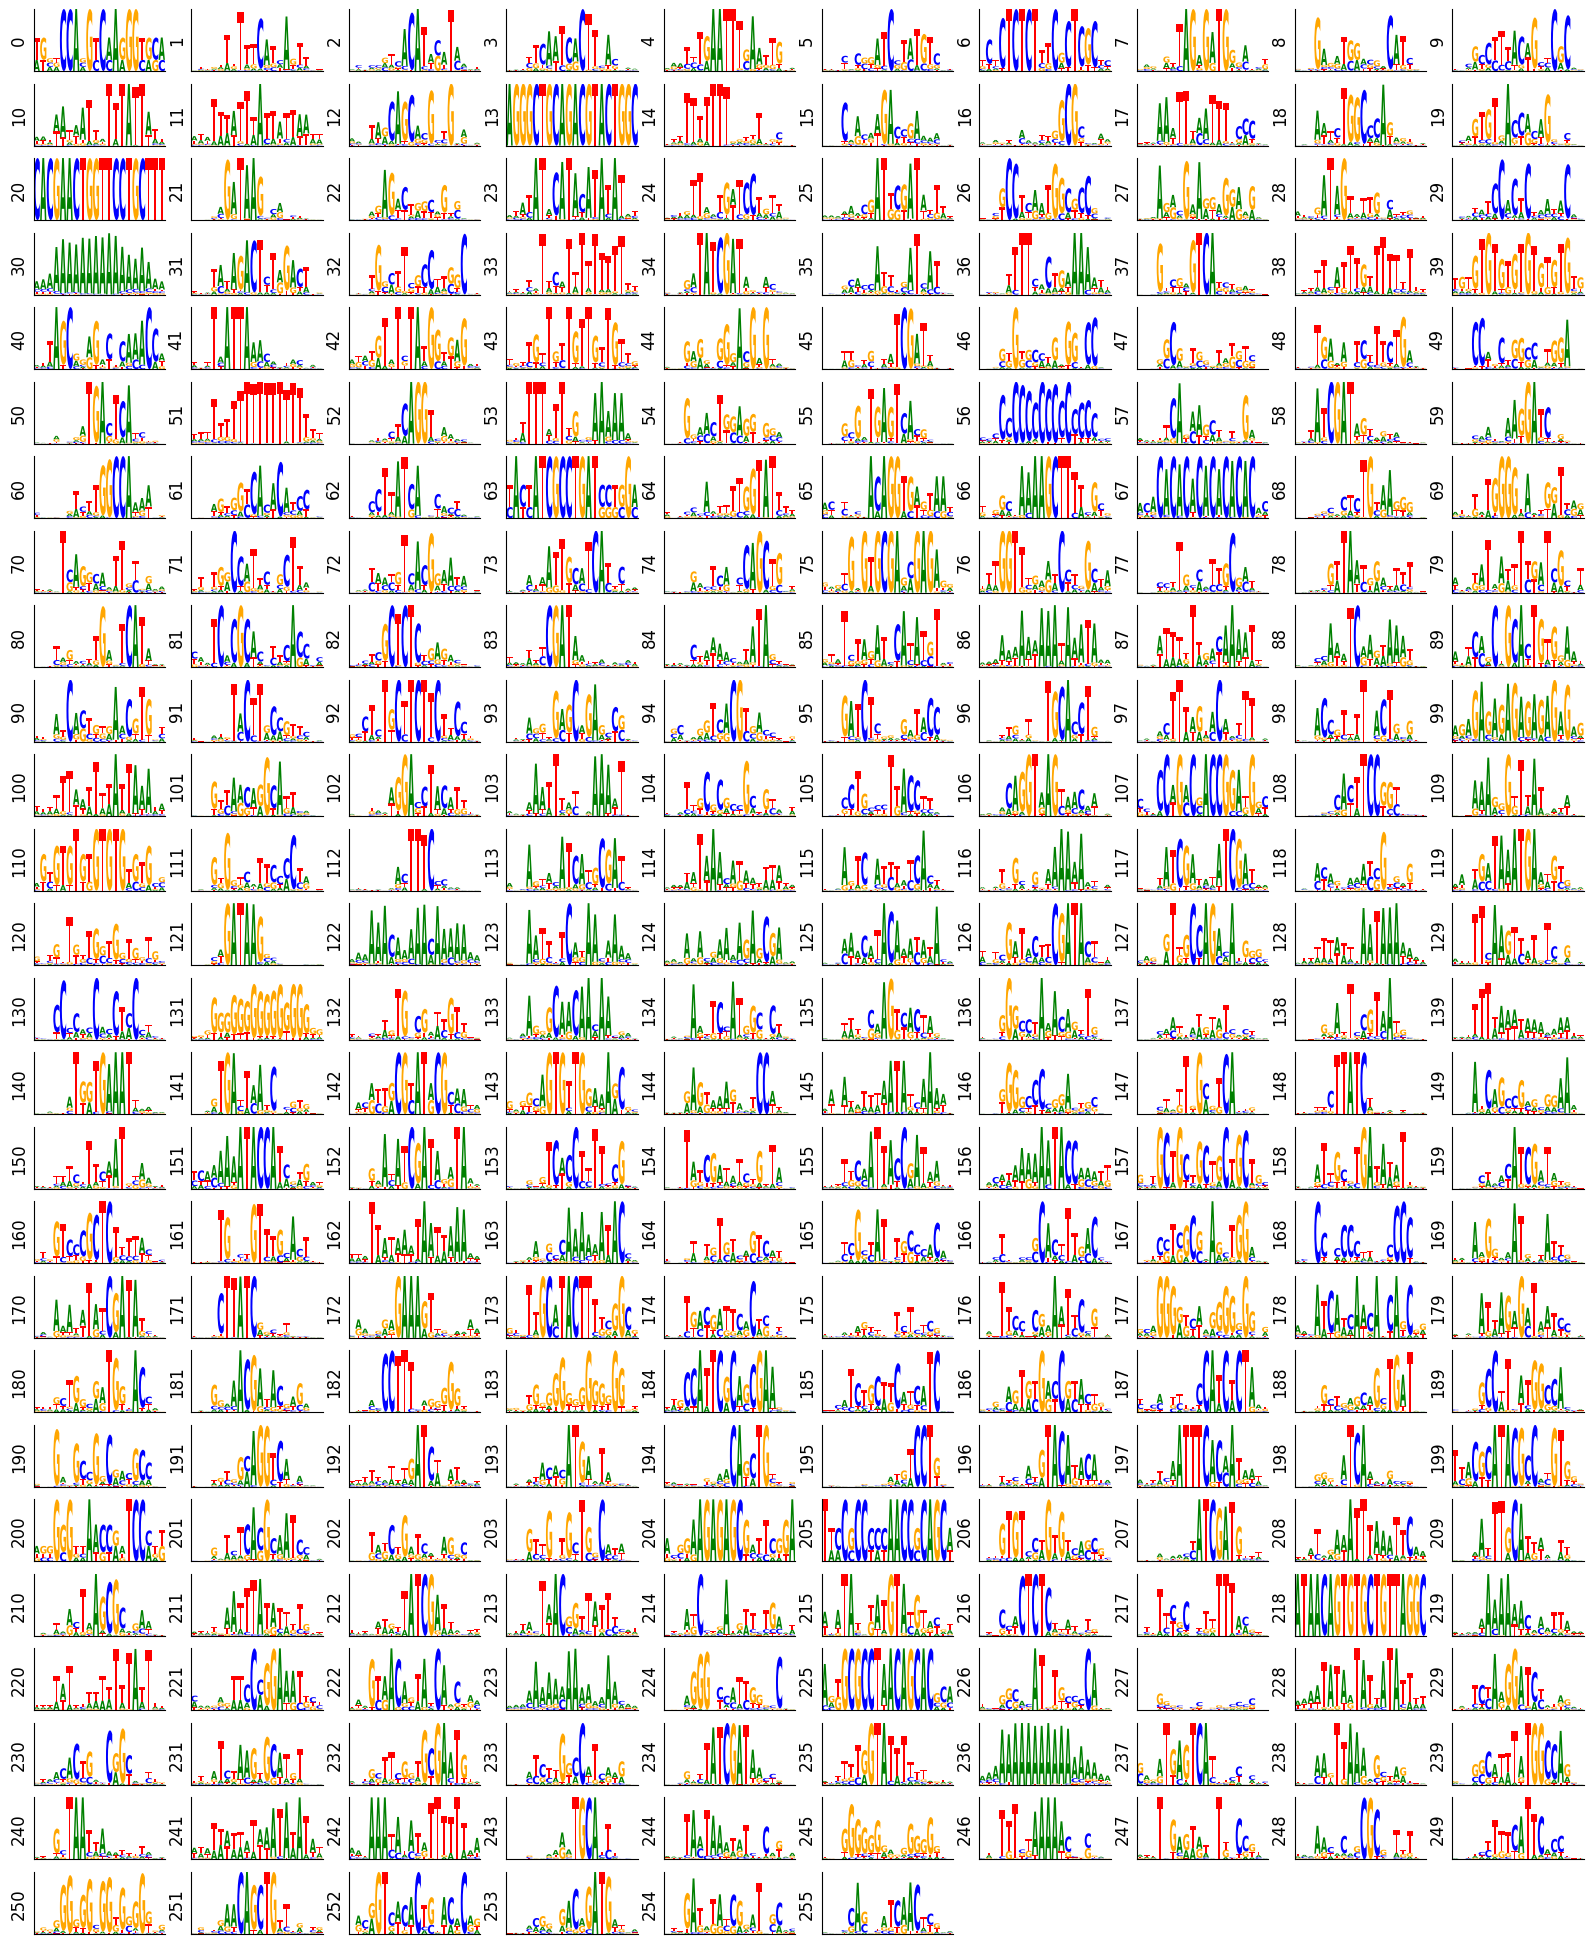

In [17]:
tuner.interpret_model(layer=layer)

In [4]:
df = pd.read_csv("/home/chandana/projects/hominid_pipeline/sweep_explore_variations.csv")

df["trial_log_path"].to_list()

superset = [{'conv1_activation': 'relu',
  'conv1_attention_pool_size': 5,
  'conv1_batchnorm': False,
  'conv1_channel_weight': 'se',
  'conv1_dropout': 0.3,
  'conv1_filters': 256,
  'conv1_kernel_size': 11,
  'conv1_max_pool': 4,
  'conv1_pool_type': 'attention',
  'conv1_type': 'pw',
  'dense_activation': 'relu',
  'dense_batchnorm': True,
  'dense_dropout': [0.3, 0.3],
  'dense_units': [256, 128],
  'mha_d_model': 192,
  'mha_dropout': 0.1,
  'mha_head_type': 'task_specific',
  'mha_heads': 4,
  'mha_layernorm': False,
  'output_activation': 'linear',
  'output_shape': None},
 {'conv1_activation': 'relu',
  'conv1_attention_pool_size': 30,
  'conv1_batchnorm': False,
  'conv1_channel_weight': 'softconv',
  'conv1_dropout': 0.3,
  'conv1_filters': 128,
  'conv1_kernel_size': 19,
  'conv1_max_pool': 4,
  'conv1_pool_type': 'max_pool',
  'conv1_type': 'pw',
  'dense_activation': 'relu',
  'dense_batchnorm': True,
  'dense_dropout': [0.4, 0.4],
  'dense_units': [128, 128],
  'mha_d_model': 96,
  'mha_dropout': 0.1,
  'mha_head_type': 'pool',
  'mha_heads': 8,
  'mha_layernorm': False,
  'output_activation': 'linear',
  'output_shape': None},
 {'conv1_activation': 'relu',
  'conv1_attention_pool_size': 1,
  'conv1_batchnorm': False,
  'conv1_channel_weight': None,
  'conv1_dropout': 0.1,
  'conv1_filters': 128,
  'conv1_kernel_size': 15,
  'conv1_max_pool': 0,
  'conv1_pool_type': 'attention',
  'conv1_type': 'pw',
  'dense_activation': 'relu',
  'dense_batchnorm': True,
  'dense_dropout': [0.4, 0.4],
  'dense_units': [256, 128],
  'mha_d_model': 96,
  'mha_dropout': 0.2,
  'mha_head_type': 'pool',
  'mha_heads': 4,
  'mha_layernorm': False,
  'output_activation': 'linear',
  'output_shape': None}]

In [19]:
# get from path
save_dir = "/home/chandana/projects/hominid_pipeline/experiments/model_variations"

for i, save_path in enumerate(df["trial_log_path"].to_list()):

    config = superset[i]
    config["input_shape"] = (249, 4)
    config["output_shape"] = 2

#     print(yaml.dump(config, default_flow_style=False))

    path = save_path.split("tune_hominid_v2")[-1]
#     print(path)


    
    for activation in ["exponential", "relu"]:
        save_path = f"{save_dir}{path}/{activation}"
        print(save_path)
        print()
        Path(save_path).mkdir(exist_ok=True, parents=True)
        
        config["conv1_activation"] = activation
        config["conv1_kernel_size"] = 15
        config["conv1_max_pool"] = 8
        
        if(activation == "exponential"):
            config['conv1_batchnorm'] = True
        else:
            config['conv1_batchnorm'] = False
        
    
        with open(os.path.join(save_path, 'config.yaml'), 'w') as file:
            documents = yaml.dump(config, file)    


        command = f"python train.py --config_file={save_path}/config.yaml"
        print(command)

        with open(f"/home/chandana/projects/hominid_pipeline/train_commands.txt", "a") as file:
            file.write(command + "\n")

/home/chandana/projects/hominid_pipeline/experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/exponential

python train.py --config_file=/home/chandana/projects/hominid_pipeline/experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/exponential/config.yaml
/home/chandana/projects/hominid_pipeline/experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/relu

python train.py --config_file=/home/chandana/projects/hominid_pipeline/experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/relu/config.y

# Interpret

In [7]:
import glob

# glob.glob("/home/chandana/projects/hominid_pipeline/experiments/model_variations/*/*/*/*.config.yaml")


['/home/chandana/projects/hominid_pipeline/experiments/model_variations/tune_hominid_8f34a_00058_58_conv1_activation=relu,conv1_attention_pool_size=30,conv1_batchnorm=False,conv1_channel_weight=softconv_2023-05-17_22-09-59/relu/config.yaml',
 '/home/chandana/projects/hominid_pipeline/experiments/model_variations/tune_hominid_8f34a_00058_58_conv1_activation=relu,conv1_attention_pool_size=30,conv1_batchnorm=False,conv1_channel_weight=softconv_2023-05-17_22-09-59/exponential/config.yaml',
 '/home/chandana/projects/hominid_pipeline/experiments/model_variations/tune_hominid_8f34a_00069_69_conv1_activation=relu,conv1_attention_pool_size=1,conv1_batchnorm=False,conv1_channel_weight=None,conv_2023-05-17_23-02-19/relu/config.yaml',
 '/home/chandana/projects/hominid_pipeline/experiments/model_variations/tune_hominid_8f34a_00069_69_conv1_activation=relu,conv1_attention_pool_size=1,conv1_batchnorm=False,conv1_channel_weight=None,conv_2023-05-17_23-02-19/exponential/config.yaml',
 '/home/chandana/p

In [29]:
config_files = glob.glob("/home/chandana/projects/hominid_pipeline/experiments/model_variations/*/*/config.yaml")
data = []

for config_file in config_files:
    
    config = hominid.load_config(config_file)
    save_path = config_file.split("config.yaml")[0][:-1]
    tuner = hominid.HominidTuner(config, epochs=1, tuning_mode=False, save_path=save_path)
    
    df = tuner.get_evaluation_results()
    print(df[["PCC_dev", "PCC_hk"]])

    frame = {
        'conv1_type': [], 
        'conv1_filters': [],
        'conv1_kernel_size': [], 
        'conv1_batchnorm': [], 
        'conv1_activation': [],
        'conv1_dropout': [], 
        'conv1_channel_weight': [], 
        'conv1_pool_type': [],
        'conv1_attention_pool_size': [], 
        'conv1_max_pool': [], 
        'mha_heads': [],
        'mha_head_type': [], 
        'mha_d_model': [], 
        'mha_dropout': [], 
        'dense_units': [],
        'dense_dropout': [], 
    }

    for key in frame:
        frame[key] += [config[key]]

    frame['trial_log_path'] = [save_path]

    frame = pd.DataFrame(frame)

    data += [pd.concat([df[["PCC_dev", "PCC_hk"]], frame], axis=1)]
    
results = pd.concat(data, axis=0)

results = results.sort_values(f"PCC_dev", ascending=False)
results.drop(columns=["trial_log_path"])

#     command = f"python filters.py --config_file={save_path}/config.yaml"
#     print(command)
    
#     with open(f"/home/chandana/projects/hominid_pipeline/filter_commands.txt", "a") as file:
#         file.write(command + "\n")
    

    PCC_dev    PCC_hk
0  0.708425  0.781696
    PCC_dev    PCC_hk
0  0.542731  0.669031
    PCC_dev    PCC_hk
0  0.690445  0.768462
    PCC_dev    PCC_hk
0  0.681595  0.761105
    PCC_dev    PCC_hk
0  0.704725  0.780997
    PCC_dev    PCC_hk
0  0.691151  0.767116


,PCC_dev,PCC_hk,conv1_type,conv1_filters,conv1_kernel_size,conv1_batchnorm,conv1_activation,conv1_dropout,conv1_channel_weight,conv1_pool_type,conv1_attention_pool_size,conv1_max_pool,mha_heads,mha_head_type,mha_d_model,mha_dropout,dense_units,dense_dropout
0,0.708425,0.781696,pw,128,15,False,relu,0.3,softconv,max_pool,30,8,8,pool,96,0.1,"[128, 128]","[0.4, 0.4]"
0,0.704725,0.780997,pw,256,15,False,relu,0.3,se,attention,5,8,4,task_specific,192,0.1,"[256, 128]","[0.3, 0.3]"
0,0.691151,0.767116,pw,256,15,True,exponential,0.3,se,attention,5,8,4,task_specific,192,0.1,"[256, 128]","[0.3, 0.3]"
0,0.690445,0.768462,pw,128,15,False,relu,0.1,None,attention,1,8,4,pool,96,0.2,"[256, 128]","[0.4, 0.4]"
0,0.681595,0.761105,pw,128,15,True,exponential,0.1,None,attention,1,8,4,pool,96,0.2,"[256, 128]","[0.4, 0.4]"
0,0.542731,0.669031,pw,128,15,True,exponential,0.3,softconv,max_pool,30,8,8,pool,96,0.1,"[128, 128]","[0.4, 0.4]"


In [36]:
results.to_csv("/home/chandana/projects/hominid_pipeline/results/hominid_tune_subset_results.csv", index=None)

In [ ]:
# get from path
save_dir = "/home/chandana/projects/hominid_pipeline/experiments/model_variations"

for i, save_path in enumerate(df["trial_log_path"].to_list()):




        command = f"python train.py --config_file={save_path}/config.yaml"
        print(command)

        with open(f"/home/chandana/projects/hominid_pipeline/train_commands.txt", "a") as file:
            file.write(command + "\n")

In [11]:
variation_index = 1
save_path = f"/home/chandana/projects/hominid_pipeline/experiments/model_variations/variation_{variation_index}"

config_1 = {'conv1_activation': 'relu',
  'conv1_attention_pool_size': 5,
  'conv1_batchnorm': False,
  'conv1_channel_weight': 'se',
  'conv1_dropout': 0.3,
  'conv1_filters': 128,
  'conv1_kernel_size': 11,
  'conv1_max_pool': 4,
  'conv1_pool_type': 'attention',
  'conv1_type': 'pw',
  'dense_activation': 'relu',
  'dense_batchnorm': True,
  'dense_dropout': [0.3, 0.3],
  'dense_units': [256, 128],
  'mha_d_model': 192,
  'mha_dropout': 0.1,
  'mha_head_type': 'task_specific',
  'mha_heads': 4,
  'mha_layernorm': False,
  'output_activation': 'linear',
  'output_shape': None
}

tuner = hominid.HominidTuner(config, epochs=30, tuning_mode=False, save_path=save_path)

# train model
tuner.execute()

# interpret model
tuner.interpret_model(layer=3)

if(config['conv1_channel_weight'] == "softconv"):
        layer = 5
elif(config['conv1_channel_weight'] == "se"):
    layer = 8
else:
    print("Finished interpreting!")

Input shape: (402296, 249, 4). Output shape: 2
Building model...


2023-05-24 15:27:59.153752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 15:27:59.693188: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 699 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:21:00.0, compute capability: 8.6


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 249, 4)]     0           []                               
                                                                                                  
 pairwise_conv1d (PairwiseConv1  (None, 249, 256)    468736      ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 249, 256)     1024        ['pairwise_conv1d[0][0]']        
                                                                                                  
 conv1_activation (Activation)  (None, 249, 256)     0           ['conv1_bn[0][0]']           

 dense_15 (Dense)               (None, 1)            257         ['dropout_5[0][0]']              
                                                                                                  
 tf.concat (TFOpLambda)         (None, 2)            0           ['dense_7[0][0]',                
                                                                  'dense_15[0][0]']               
                                                                                                  
Total params: 3,298,114
Trainable params: 3,295,554
Non-trainable params: 2,560
__________________________________________________________________________________________________


2023-05-24 15:28:11.722880: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.49GiB (rounded to 1602747392)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-05-24 15:28:11.722948: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2023-05-24 15:28:11.722967: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 24, Chunks in use: 24. 6.0KiB allocated for chunks. 6.0KiB in use in bin. 104B client-requested in use in bin.
2023-05-24 15:28:11.722980: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 6, Chunks in use: 6. 3.0KiB allocated for chunks. 3.0KiB in use in bin. 2.2KiB client-requested in use in bin.
2023-05-24 15:28:11.722994: I tensorflow/tsl/framework/bfc_

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [34]:
import glob


len(glob.glob("/home/chandana/projects/hominid_pipeline/experiments/sweeps/*"))

216

In [10]:
!echo $CUDA_VISIBLE_DEVICES

1
